# Setup, imports

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/honours
%ls

/content/drive/.shortcut-targets-by-id/19ffbnjWUM9FX-8Hcysq3IAN9wHHnO781/honours
actual_afp.csv  all/                      model_creation.py  predicted_gwc.csv  run_5fold.py
actual_dbd.csv  D1actual_wsa.csv          model_plot.png     predicted_tp.csv   saturated/
actual_gwc.csv  D1predicted_wsa.csv       nonsaturated/      predicted_vwc.csv  sheets/
actual_tp.csv   dried/                    plot_functions.py  predicted_wsa.csv
actual_vwc.csv  feature_extraction.py     predicted_afp.csv  prep_functions.py
actual_wsa.csv  hyperparameter_tuning.py  predicted_dbd.csv  __pycache__/


In [5]:
from prep_functions import create_images_list, circle_cut_out, scale_fit_transform,extract_gh_values,extract_lp_values,custom_kfold_split
from plot_functions import plot_metrics,lin_regression,plot_predictions,plot_all_validation
from model_creation import build_vgg,build_resnet,build_inception,build_densenet,build_custom
from run_5fold import run_5fold,model_dict

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow #colab bug with imshow

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Preparing data

In [7]:
#loading two datasets into respective dataframes
gh_df = pd.read_csv('/content/drive/MyDrive/honours/sheets/GrievesHouse.csv')
lp_df = pd.read_csv('/content/drive/MyDrive/honours/sheets/LowerPilmore.csv')

gh_df.head()

,Sample,Stable aggregates (%)
0,1,65.88
1,2,23.90
2,2,31.86
3,3,89.14
4,4,68.71


In [8]:
# creating lists of images(scaled down) and respective label
gh_path = "/content/drive/MyDrive/honours/all/GrievesHouse/*.*"
lp_path = "/content/drive/MyDrive/honours/all/LowerPilmore/*.*"

gh_gray,gh_labels = create_images_list(gh_path,(256,256),True)
lp_gray,lp_labels = create_images_list(lp_path,(256,256),True)

gh_colour,gh_labels = create_images_list(gh_path,(256,256))
lp_colour,lp_labels = create_images_list(lp_path,(256,256))


In [9]:
gh_values = extract_gh_values(gh_labels,gh_df)
lp_values = extract_lp_values(lp_labels,lp_df)

# Data distributions

### Total WSA

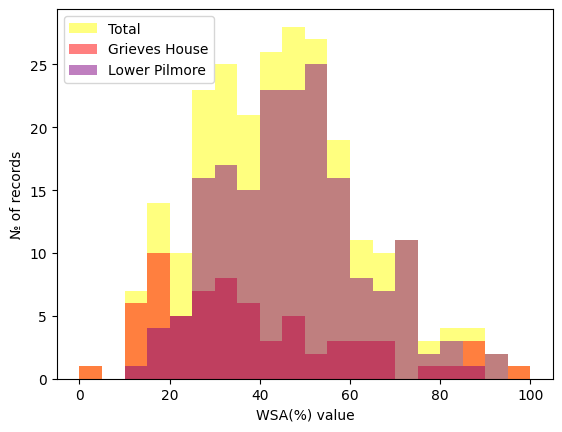

In [10]:
binwidth = 5
plt.hist(lp_values + gh_values, range(0, 101, binwidth),label='Total',alpha=0.5, color='yellow')

plt.hist(gh_values, range(0, 101, binwidth),label='Grieves House',alpha=0.5, color='red')

plt.hist(lp_values, range(0, 101, binwidth),label='Lower Pilmore',alpha=0.5, color='purple')

plt.legend(loc='upper left')
plt.ylabel("№ of records")
plt.xlabel("WSA(%) value")

plt.show()

In [11]:
# For both datasets
print("Mean: ", np.mean(lp_values + gh_values))
print("Median", (np.median(lp_values + gh_values)))
print("Standard Deviation: ", np.std(lp_values + gh_values))

Mean:  45.0125371120108
Median 44.55
Standard Deviation:  18.216985754202604


In [12]:
# Lower Pilmore quantiles
lp_df['aggregates stability (%)'].describe()

count    195.000000
mean      48.045641
std       16.821670
min       10.060000
25%       35.235000
50%       48.790000
75%       58.615000
max       91.410000
Name: aggregates stability (%), dtype: float64

In [13]:
# Grieves House quantiles
gh_df['Stable aggregates (%)'].describe()

count    76.000000
mean     37.759605
std      22.056073
min       4.830000
25%      20.475000
50%      31.645000
75%      50.257500
max      97.230000
Name: Stable aggregates (%), dtype: float64

# Normalising data

In [14]:
gh_gray_norm = [circle_cut_out(i[:, :, np.newaxis]) for i in gh_gray]
lp_gray_norm = [circle_cut_out(i[:, :, np.newaxis]) for i in lp_gray]
gh_gray_norm = [img / 255 for img in gh_gray]
lp_gray_norm = [img / 255 for img in lp_gray]

gh_colour = [circle_cut_out(i) for i in gh_colour]
lp_colour = [circle_cut_out(i) for i in lp_colour]

gh_colour_norm = [img / 255 for img in gh_colour]
lp_colour_norm = [img / 255 for img in lp_colour]

In [15]:
# for custom cnn without pretrained weights
X_gray = gh_gray_norm + lp_gray_norm

#for imported models without pretrained weights
X_col_norm = gh_colour_norm + lp_colour_norm

# for imported models that have their own preprocessing functions
X_col = gh_colour + lp_colour

all_wsa_values = gh_values + lp_values
all_wsa_values = np.array(all_wsa_values).reshape(-1, 1)

In [16]:
del lp_gray_norm,gh_gray_norm, gh_colour,lp_colour,gh_colour_norm,lp_colour_norm

In [17]:
X_gray = np.reshape(X_gray, (len(X_gray),256,256,1))
X_col = np.reshape(X_col,(len(X_col),256,256,3))
X_col_norm = np.reshape(X_col_norm,(len(X_col_norm),256,256,3))

y = all_wsa_values


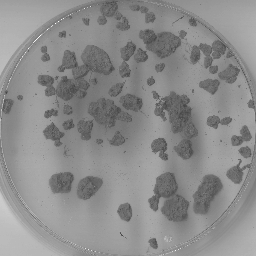

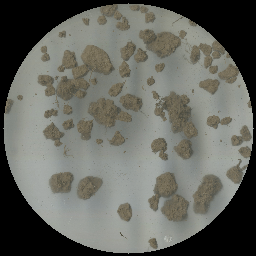

In [18]:
cv2_imshow(X_gray[1] * 255)
cv2_imshow(X_col[1])

# Models

In [20]:
kf = KFold(n_splits=5,shuffle=True,random_state=42)

splits = []
for i,(train_idx,test_idx) in enumerate(kf.split(X_col)):
  splits.append((train_idx,test_idx))

## Simple CNN

------------------------------------------------------------------
------------------------------Fold 0------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 11s 311ms/step - loss: 1.6614 - mean_absolute_error: 0.9927 - root_mean_squared_error: 1.2890 - val_loss: 0.8111 - val_mean_absolute_error: 0.7414 - val_root_mean_squared_error: 0.9006
Epoch 2/20
7/7 [==============================] - 0s 56ms/step - loss: 1.0069 - mean_absolute_error: 0.8124 - root_mean_squared_error: 1.0034 - val_loss: 0.8194 - val_mean_absolute_error: 0.7435 - val_root_mean_squared_error: 0.9052
Epoch 3/20
7/7 [==============================] - 0s 57ms/step - loss: 1.0317 - mean_absolute_error: 0.8116 - root_mean_squared_error: 1.0157 - val_loss: 0.8078 - val_mean_absolute_error: 0.7415 - val_root_mean_squared_error: 0.8988
Epoch 4/20
7/7 [==============================] - 0s 61ms/step - loss: 1.0056 - mean_absolute_erro

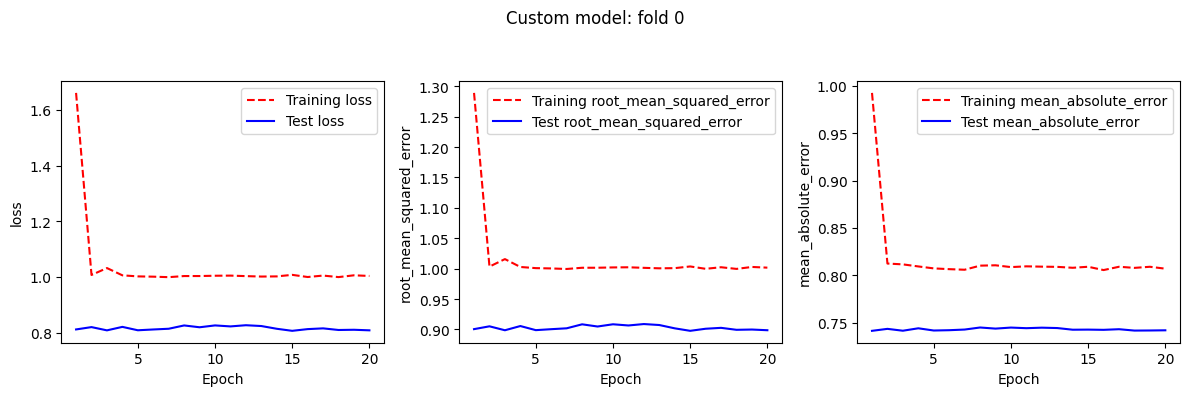

7/7 [==============================] - 0s 22ms/step


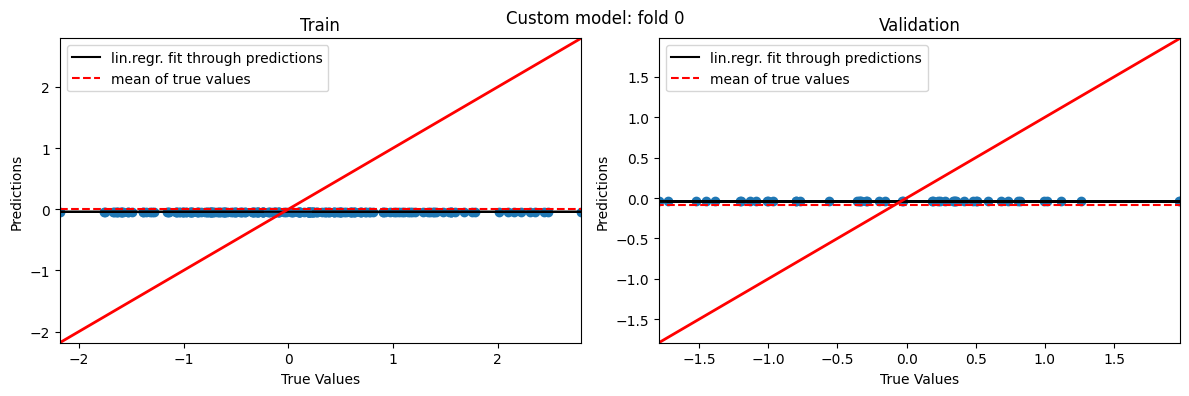

------------------------------------------------------------------
------------------------------Fold 1------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 2s 104ms/step - loss: 1.0394 - mean_absolute_error: 0.8265 - root_mean_squared_error: 1.0195 - val_loss: 1.4229 - val_mean_absolute_error: 1.0045 - val_root_mean_squared_error: 1.1929
Epoch 2/20
7/7 [==============================] - 0s 63ms/step - loss: 0.9995 - mean_absolute_error: 0.8001 - root_mean_squared_error: 0.9997 - val_loss: 1.3732 - val_mean_absolute_error: 0.9780 - val_root_mean_squared_error: 1.1718
Epoch 3/20
7/7 [==============================] - 0s 61ms/step - loss: 1.0033 - mean_absolute_error: 0.8069 - root_mean_squared_error: 1.0016 - val_loss: 1.3683 - val_mean_absolute_error: 0.9742 - val_root_mean_squared_error: 1.1698
Epoch 4/20
7/7 [==============================] - 0s 69ms/step - loss: 1.0029 - mean_absolute_error

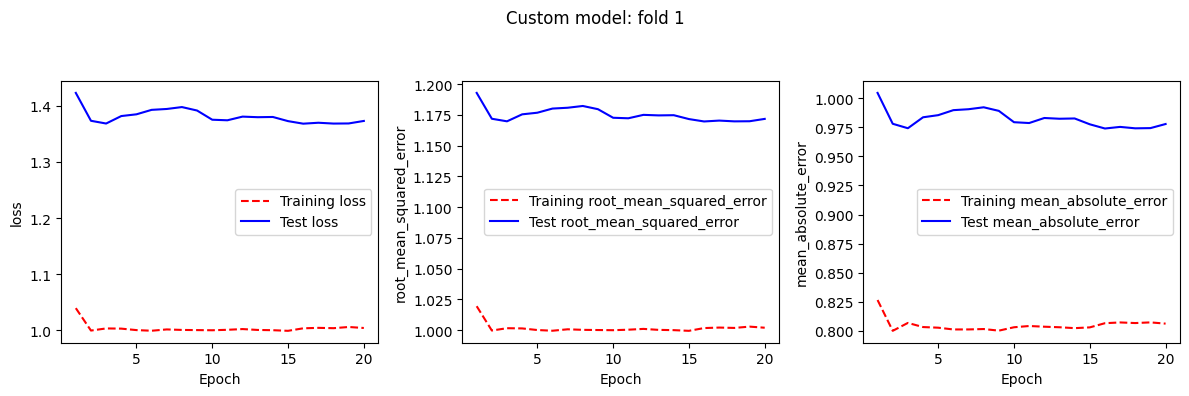

7/7 [==============================] - 0s 14ms/step


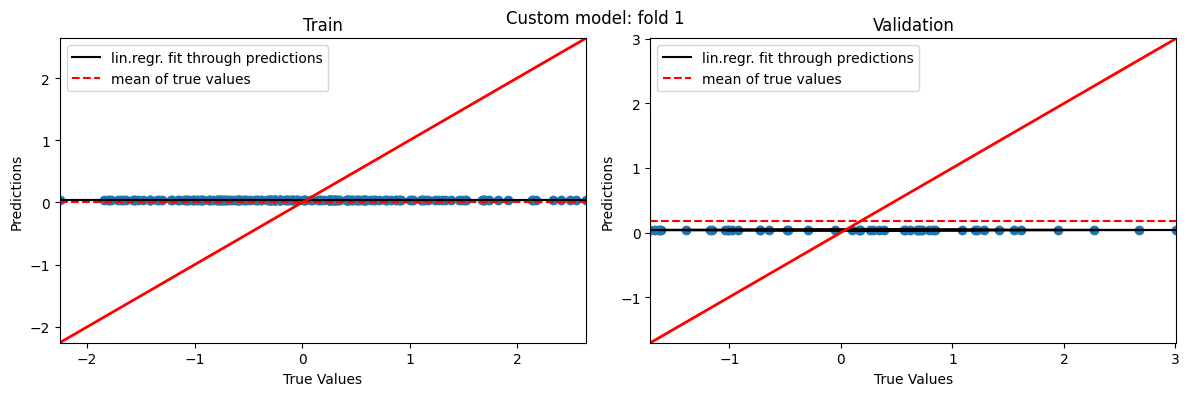

------------------------------------------------------------------
------------------------------Fold 2------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 4s 388ms/step - loss: 1.3971 - mean_absolute_error: 0.9353 - root_mean_squared_error: 1.1820 - val_loss: 0.9827 - val_mean_absolute_error: 0.7793 - val_root_mean_squared_error: 0.9913
Epoch 2/20
7/7 [==============================] - 0s 65ms/step - loss: 1.0131 - mean_absolute_error: 0.8195 - root_mean_squared_error: 1.0066 - val_loss: 0.9713 - val_mean_absolute_error: 0.7720 - val_root_mean_squared_error: 0.9855
Epoch 3/20
7/7 [==============================] - 0s 74ms/step - loss: 1.0018 - mean_absolute_error: 0.8188 - root_mean_squared_error: 1.0009 - val_loss: 0.9722 - val_mean_absolute_error: 0.7628 - val_root_mean_squared_error: 0.9860
Epoch 4/20
7/7 [==============================] - 0s 71ms/step - loss: 1.0104 - mean_absolute_error

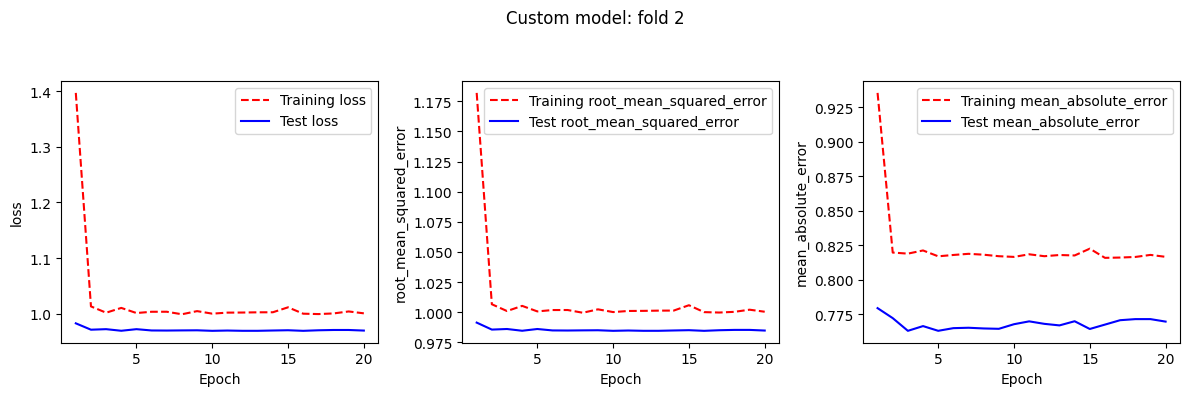

7/7 [==============================] - 0s 20ms/step


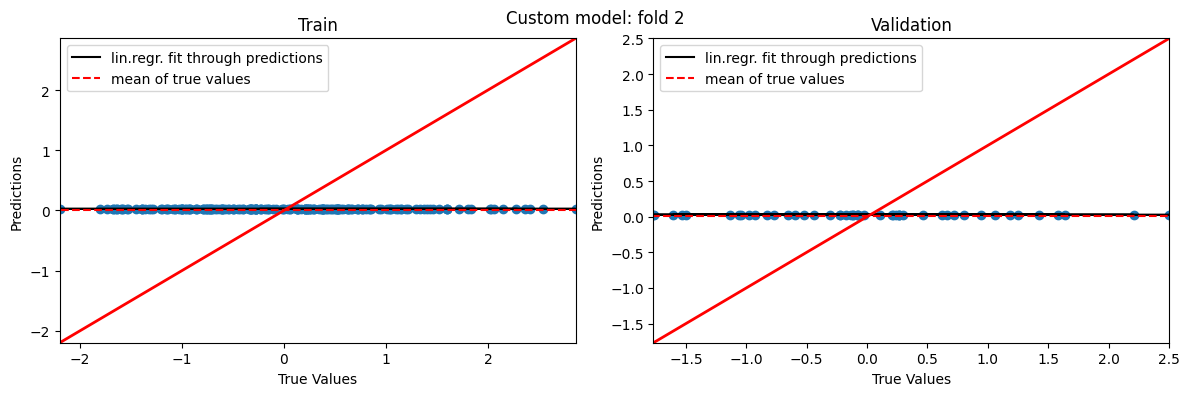

------------------------------------------------------------------
------------------------------Fold 3------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 2s 103ms/step - loss: 1.0913 - mean_absolute_error: 0.8335 - root_mean_squared_error: 1.0447 - val_loss: 1.0787 - val_mean_absolute_error: 0.8672 - val_root_mean_squared_error: 1.0386
Epoch 2/20
7/7 [==============================] - 0s 57ms/step - loss: 1.0043 - mean_absolute_error: 0.8040 - root_mean_squared_error: 1.0022 - val_loss: 1.0799 - val_mean_absolute_error: 0.8683 - val_root_mean_squared_error: 1.0392
Epoch 3/20
7/7 [==============================] - 0s 59ms/step - loss: 0.9999 - mean_absolute_error: 0.8050 - root_mean_squared_error: 1.0000 - val_loss: 1.0661 - val_mean_absolute_error: 0.8522 - val_root_mean_squared_error: 1.0325
Epoch 4/20
7/7 [==============================] - 0s 60ms/step - loss: 0.9991 - mean_absolute_error

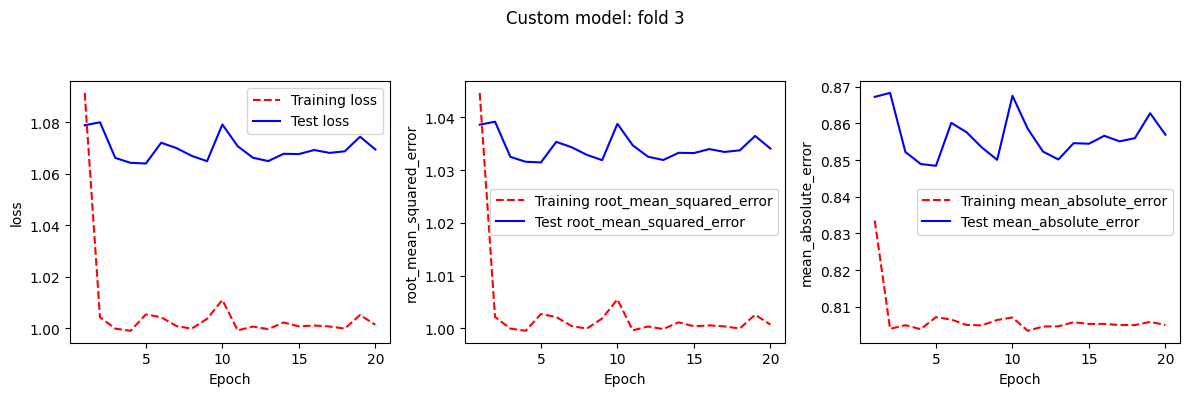

7/7 [==============================] - 0s 13ms/step


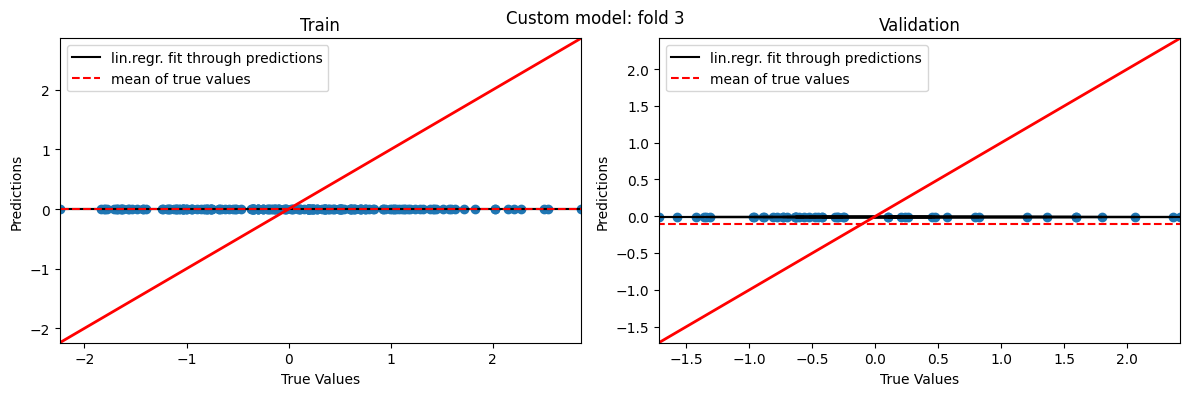

------------------------------------------------------------------
------------------------------Fold 4------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 2s 104ms/step - loss: 1.5560 - mean_absolute_error: 0.9773 - root_mean_squared_error: 1.2474 - val_loss: 0.8215 - val_mean_absolute_error: 0.7132 - val_root_mean_squared_error: 0.9064
Epoch 2/20
7/7 [==============================] - 0s 58ms/step - loss: 1.0008 - mean_absolute_error: 0.8159 - root_mean_squared_error: 1.0004 - val_loss: 0.8212 - val_mean_absolute_error: 0.7148 - val_root_mean_squared_error: 0.9062
Epoch 3/20
7/7 [==============================] - 0s 59ms/step - loss: 1.0025 - mean_absolute_error: 0.8146 - root_mean_squared_error: 1.0012 - val_loss: 0.8220 - val_mean_absolute_error: 0.7161 - val_root_mean_squared_error: 0.9066
Epoch 4/20
7/7 [==============================] - 0s 66ms/step - loss: 1.0009 - mean_absolute_error

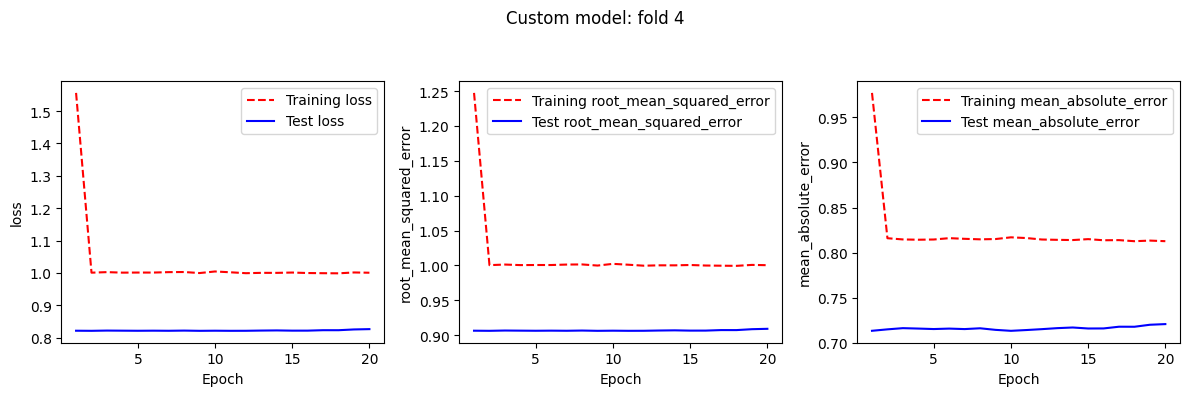

7/7 [==============================] - 0s 14ms/step


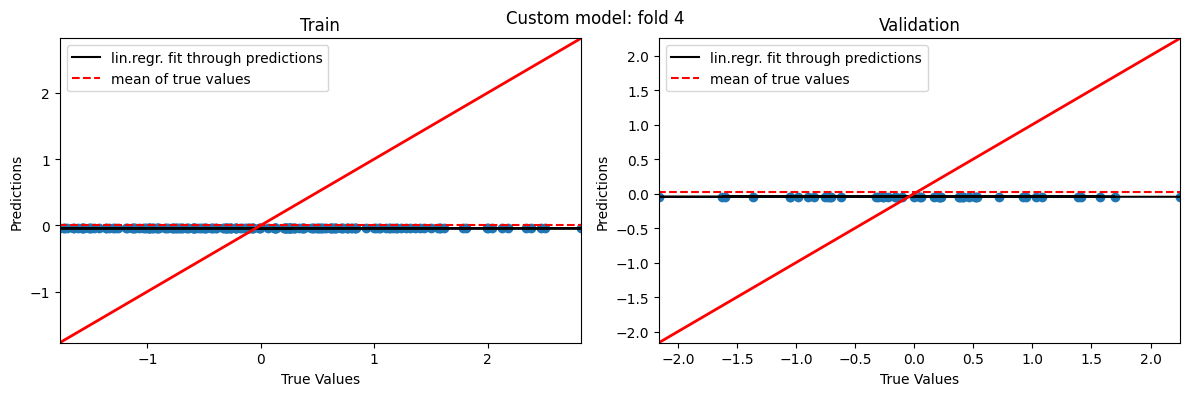

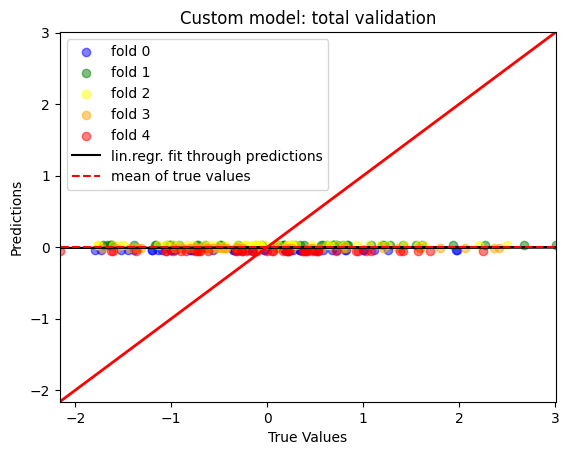

In [ ]:
all_val_preds = []
all_val_true = []
for i,(train_idx,test_idx) in enumerate(kf.split(X_gray)):
  print('-'*66)
  print('-'*30+f'Fold {i}'+'-'*30)
  print('-'*66)

  X_train = np.take(X_gray, train_idx, axis=0)
  y_train = np.take(y, train_idx, axis=0)

  X_val = np.take(X_gray, test_idx, axis=0)
  y_val = np.take(y, test_idx, axis=0)

  y_train,y_val = scale_fit_transform(y_train,y_val)

  model = build_custom((256,256,1),128,0.1,0.01)
  h = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val,y_val))
  plot_metrics(h,['loss','root_mean_squared_error','mean_absolute_error'],True,f'Custom model: fold {i}')

  y_val_pred = model.predict(X_val)
  y_train_pred = model.predict(X_train)
  all_val_preds.append(y_val_pred)
  all_val_true.append(y_val)

  plot_predictions(y_val.reshape(-1, 1),y_val_pred,y_train.reshape(-1, 1),y_train_pred,f'Custom model: fold {i}')

plot_all_validation(all_val_true,all_val_preds,'Custom model: total validation')

In [ ]:
print('Total validation RMSE:', mean_squared_error(np.concatenate(all_val_true).ravel(),np.concatenate(all_val_preds).ravel(),squared=False))
print('Total validation MAE:', mean_absolute_error(np.concatenate(all_val_true).ravel(),np.concatenate(all_val_preds).ravel()))

Total validation RMSE: 1.0049429768376317
Total validation MAE: 0.8137220244814588


# VGG16

## Random weights

------------------------------------------------------------------
------------------------------Fold 0------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 4s 312ms/step - loss: 1.0121 - mean_absolute_error: 0.8103 - root_mean_squared_error: 1.0060 - val_loss: 0.8143 - val_mean_absolute_error: 0.7429 - val_root_mean_squared_error: 0.9024
Epoch 2/20
7/7 [==============================] - 1s 188ms/step - loss: 0.9988 - mean_absolute_error: 0.8064 - root_mean_squared_error: 0.9994 - val_loss: 0.8105 - val_mean_absolute_error: 0.7420 - val_root_mean_squared_error: 0.9003
Epoch 3/20
7/7 [==============================] - 1s 187ms/step - loss: 1.0008 - mean_absolute_error: 0.8068 - root_mean_squared_error: 1.0004 - val_loss: 0.8102 - val_mean_absolute_error: 0.7419 - val_root_mean_squared_error: 0.9001
Epoch 4/20
7/7 [==============================] - 1s 183ms/step - loss: 1.0011 - mean_absolute_er

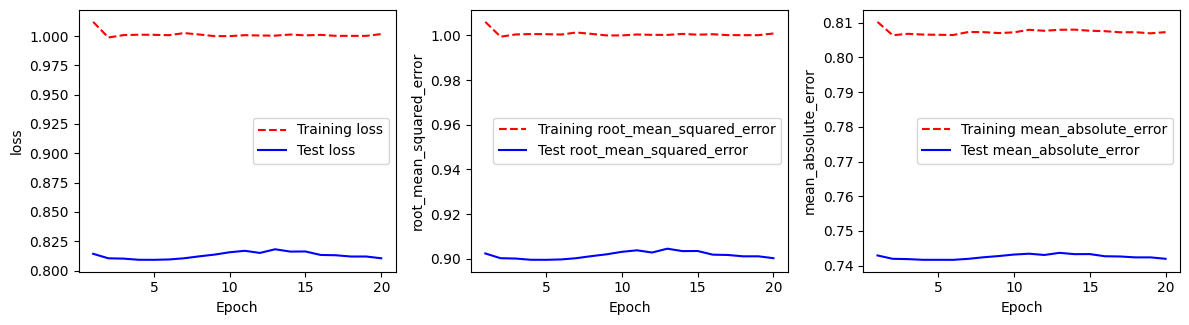

7/7 [==============================] - 1s 139ms/step


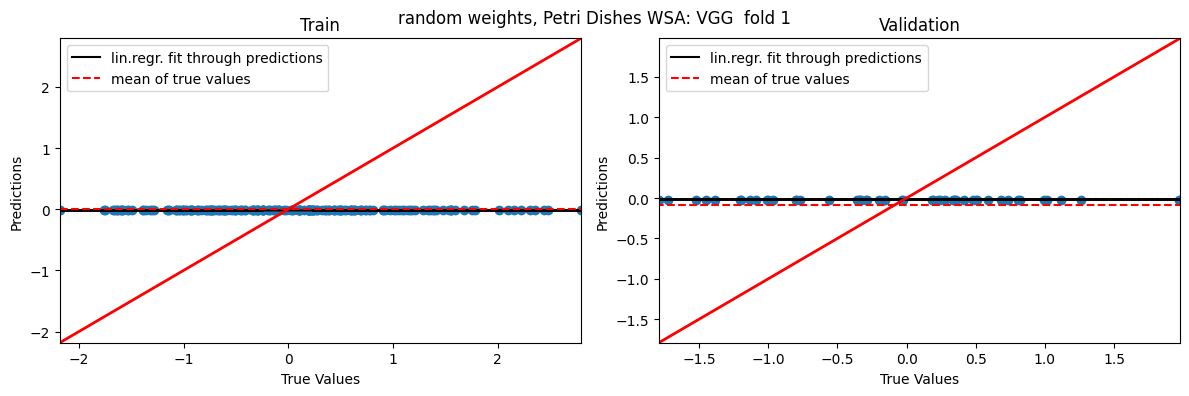

Train RMSE: 1.0001819089872142, MAE: 0.8066858268839837
Validation RMSE: 0.9002878128343474, MAE: 0.7419697091648625
------------------------------------------------------------------
------------------------------Fold 1------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 4s 244ms/step - loss: 1.0148 - mean_absolute_error: 0.8085 - root_mean_squared_error: 1.0074 - val_loss: 1.3886 - val_mean_absolute_error: 0.9876 - val_root_mean_squared_error: 1.1784
Epoch 2/20
7/7 [==============================] - 1s 179ms/step - loss: 1.0006 - mean_absolute_error: 0.8019 - root_mean_squared_error: 1.0003 - val_loss: 1.3896 - val_mean_absolute_error: 0.9881 - val_root_mean_squared_error: 1.1788
Epoch 3/20
7/7 [==============================] - 1s 186ms/step - loss: 1.0024 - mean_absolute_error: 0.8021 - root_mean_squared_error: 1.0012 - val_loss: 1.3906 - val_mean_absolute_error: 0.9887 - val_root_mean_sq

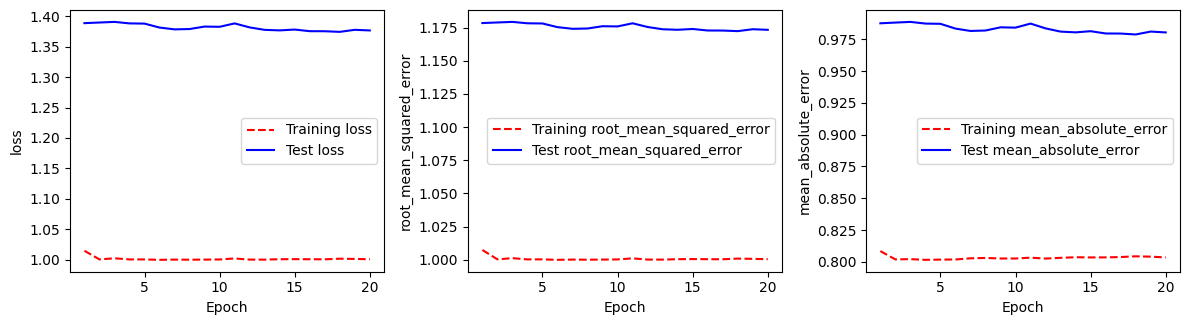

7/7 [==============================] - 1s 139ms/step


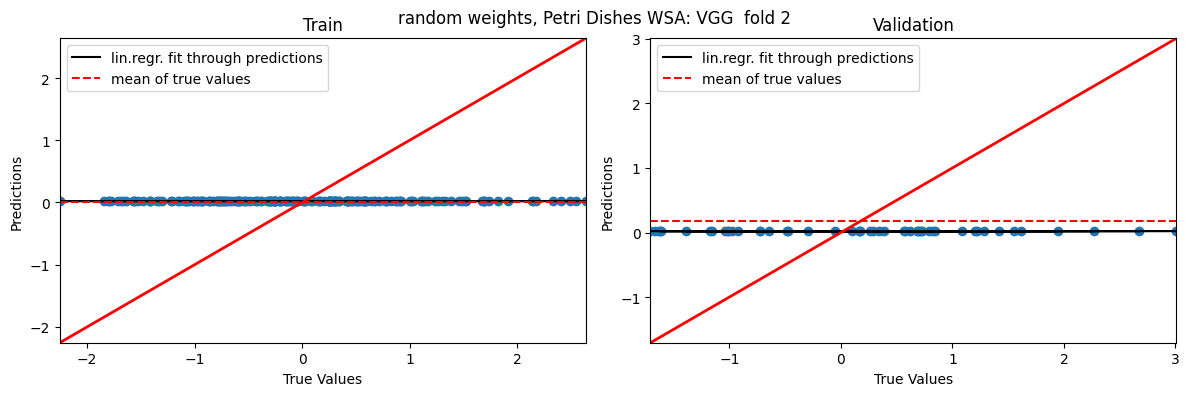

Train RMSE: 1.0002403527728265, MAE: 0.8034599476552577
Validation RMSE: 1.1732914289161005, MAE: 0.9803805466147505
------------------------------------------------------------------
------------------------------Fold 2------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 4s 271ms/step - loss: 1.0196 - mean_absolute_error: 0.8223 - root_mean_squared_error: 1.0098 - val_loss: 0.9702 - val_mean_absolute_error: 0.7704 - val_root_mean_squared_error: 0.9850
Epoch 2/20
7/7 [==============================] - 1s 192ms/step - loss: 1.0074 - mean_absolute_error: 0.8179 - root_mean_squared_error: 1.0037 - val_loss: 0.9722 - val_mean_absolute_error: 0.7727 - val_root_mean_squared_error: 0.9860
Epoch 3/20
7/7 [==============================] - 1s 196ms/step - loss: 1.0061 - mean_absolute_error: 0.8183 - root_mean_squared_error: 1.0030 - val_loss: 0.9704 - val_mean_absolute_error: 0.7708 - val_root_mean_sq

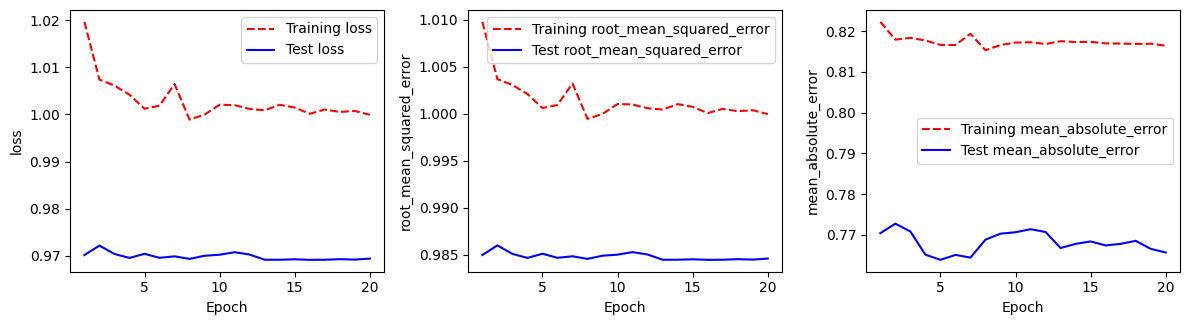

7/7 [==============================] - 1s 138ms/step


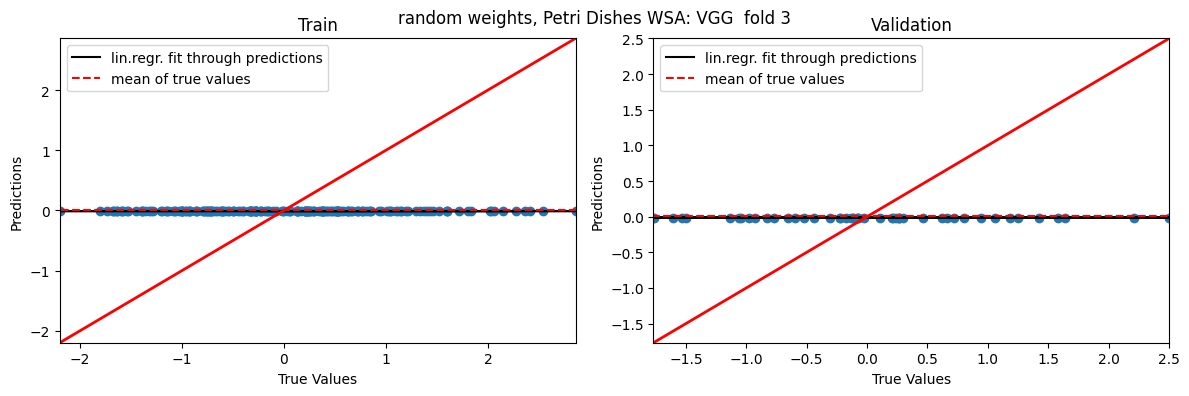

Train RMSE: 1.0000240701224705, MAE: 0.8164887136951497
Validation RMSE: 0.9845977109324798, MAE: 0.7656603043328596
------------------------------------------------------------------
------------------------------Fold 3------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 3s 243ms/step - loss: 1.0158 - mean_absolute_error: 0.8082 - root_mean_squared_error: 1.0079 - val_loss: 1.0663 - val_mean_absolute_error: 0.8525 - val_root_mean_squared_error: 1.0326
Epoch 2/20
7/7 [==============================] - 1s 182ms/step - loss: 1.0133 - mean_absolute_error: 0.8089 - root_mean_squared_error: 1.0066 - val_loss: 1.0730 - val_mean_absolute_error: 0.8613 - val_root_mean_squared_error: 1.0359
Epoch 3/20
7/7 [==============================] - 1s 190ms/step - loss: 0.9993 - mean_absolute_error: 0.8063 - root_mean_squared_error: 0.9996 - val_loss: 1.0604 - val_mean_absolute_error: 0.8400 - val_root_mean_sq

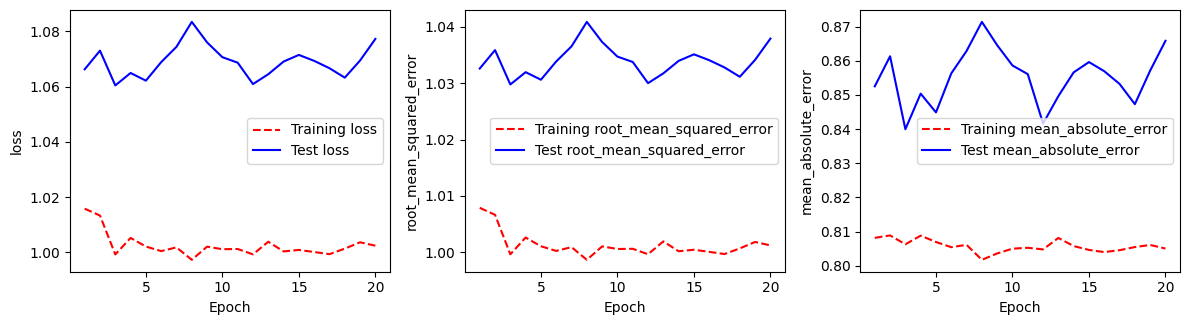

7/7 [==============================] - 1s 139ms/step


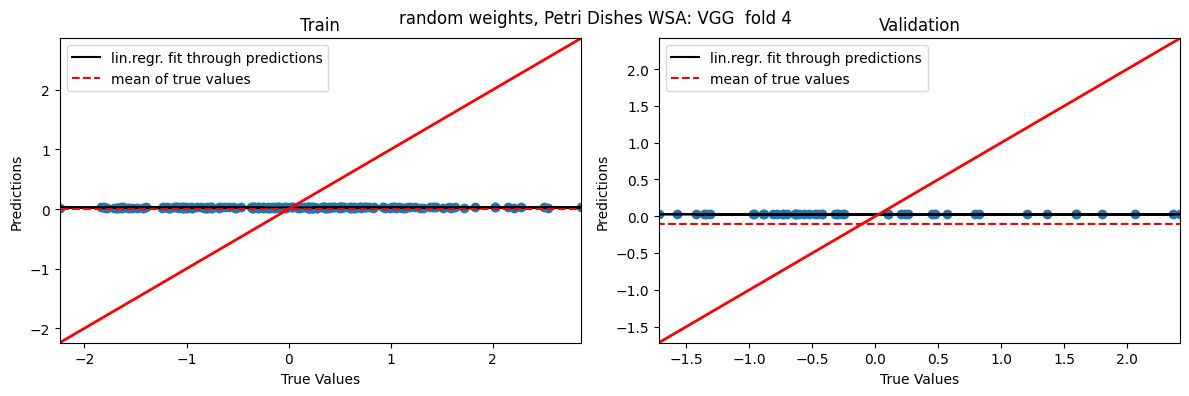

Train RMSE: 1.00022862564041, MAE: 0.803675504759821
Validation RMSE: 1.0379089841025526, MAE: 0.8658327028961211
------------------------------------------------------------------
------------------------------Fold 4------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 4s 274ms/step - loss: 1.0147 - mean_absolute_error: 0.8176 - root_mean_squared_error: 1.0073 - val_loss: 0.8246 - val_mean_absolute_error: 0.7192 - val_root_mean_squared_error: 0.9081
Epoch 2/20
7/7 [==============================] - 1s 184ms/step - loss: 1.0004 - mean_absolute_error: 0.8139 - root_mean_squared_error: 1.0002 - val_loss: 0.8213 - val_mean_absolute_error: 0.7148 - val_root_mean_squared_error: 0.9062
Epoch 3/20
7/7 [==============================] - 1s 192ms/step - loss: 1.0009 - mean_absolute_error: 0.8156 - root_mean_squared_error: 1.0005 - val_loss: 0.8212 - val_mean_absolute_error: 0.7146 - val_root_mean_squar

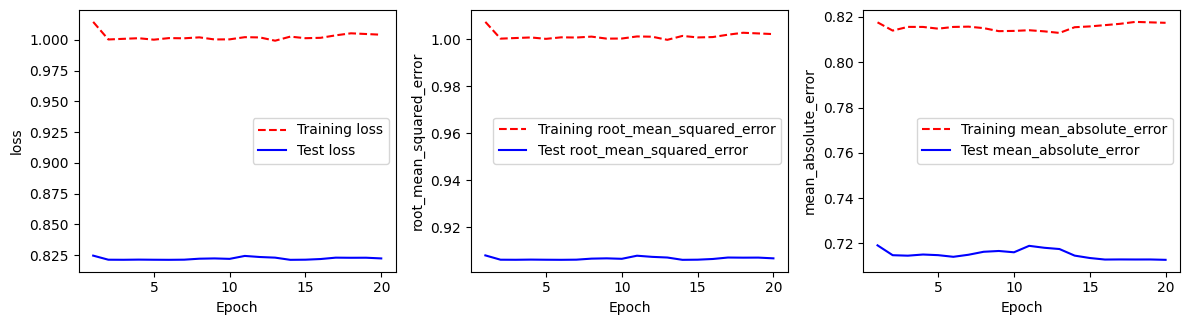

7/7 [==============================] - 1s 138ms/step


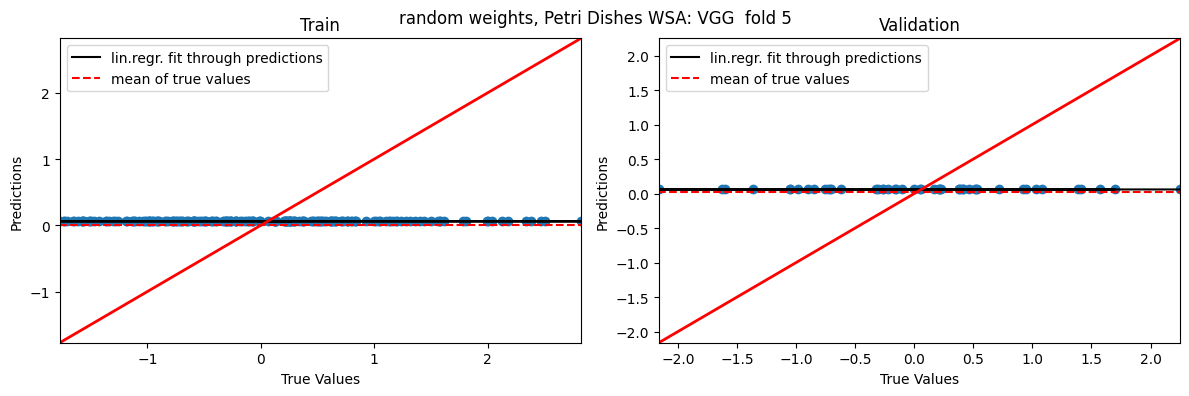

Train RMSE: 1.0017794762545447, MAE: 0.8170823890591584
Validation RMSE: 0.9068176800014831, MAE: 0.7127870029849


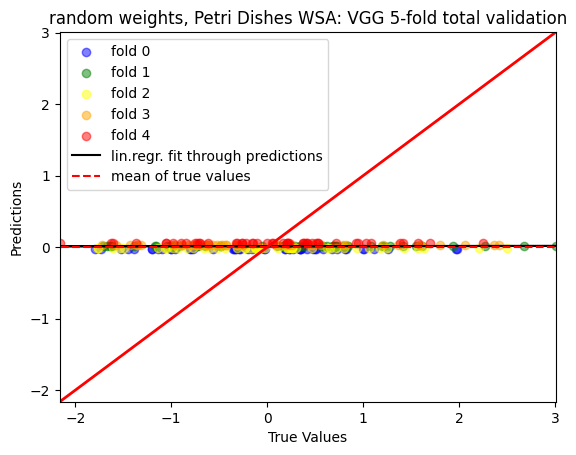

Total validation RMSE: 1.0059294671866912
Total validation MAE: 0.8137134950990316


In [26]:
run_5fold('VGG','random weights, Petri Dishes','WSA', model_dict,splits,X_col_norm,y,True,build_vgg,True,False)

## Pretrained weights

------------------------------------------------------------------
------------------------------Fold 0------------------------------
------------------------------------------------------------------
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
7/7 [==============================] - 3s 225ms/step - loss: 1959.5366 - mean_absolute_error: 27.0071 - root_mean_squared_error: 44.2667 - val_loss: 30.8304 - val_mean_absolute_error: 5.3706 - val_root_mean_squared_error: 5.5525
Epoch 2/20
7/7 [==============================] - 1s 194ms/step - loss: 25.5558 - mean_absolute_error: 4.5175 - root_mean_squared_error: 5.0553 - val_loss: 1.2460 - val_mean_absolute_error: 0.9675 - val_root_mean_squared_error: 1.1162
Epoch 3/20
7/7 [==============================] - 1s 196ms/step - loss: 3.7717 - mean_absolute_error: 1.5721 - root_mean_squared_error: 1.9421 - val_loss: 3.3813 - val_mean_absolute_error: 1.6265 - val_root_mean_squared_error: 1.8388
Epoch 4/20
7/7 [=========

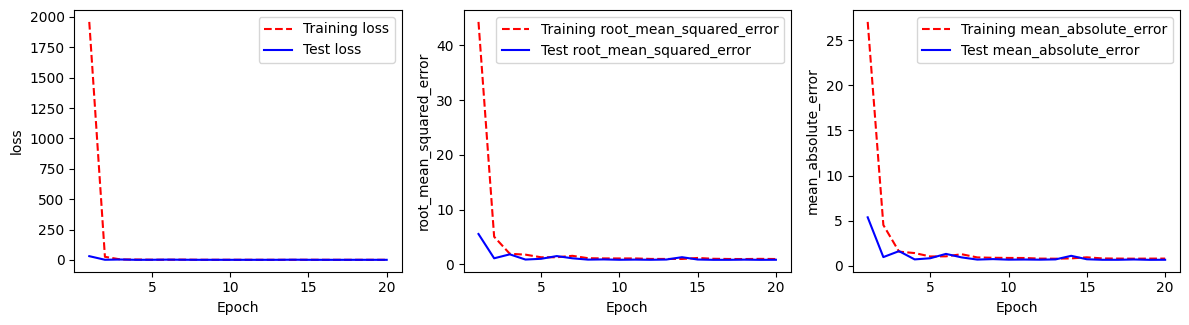

7/7 [==============================] - 1s 146ms/step


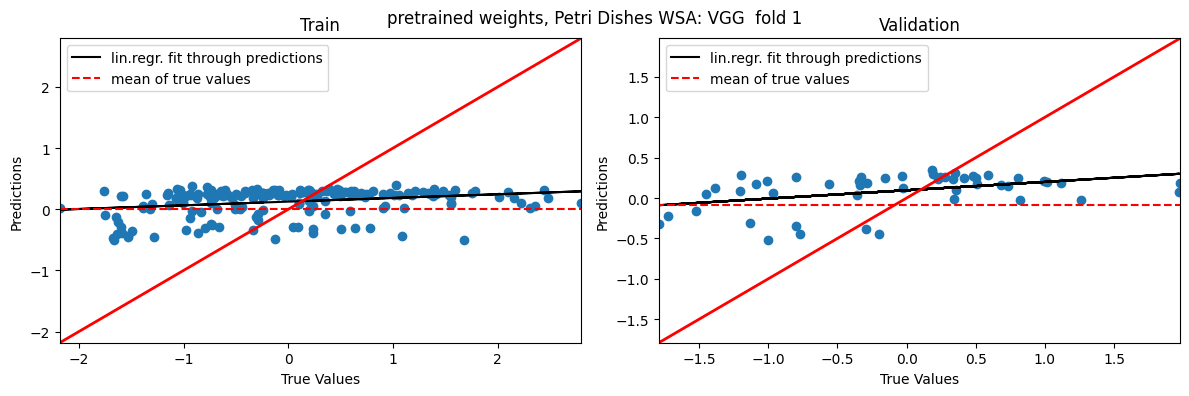

Train RMSE: 0.9724412939627971, MAE: 0.7887731801196624
Validation RMSE: 0.8496181085095998, MAE: 0.6710321674925878
------------------------------------------------------------------
------------------------------Fold 1------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 4s 230ms/step - loss: 1896.2966 - mean_absolute_error: 25.6210 - root_mean_squared_error: 43.5465 - val_loss: 26.0826 - val_mean_absolute_error: 4.9649 - val_root_mean_squared_error: 5.1071
Epoch 2/20
7/7 [==============================] - 1s 187ms/step - loss: 24.8626 - mean_absolute_error: 4.1370 - root_mean_squared_error: 4.9862 - val_loss: 6.2778 - val_mean_absolute_error: 2.2479 - val_root_mean_squared_error: 2.5055
Epoch 3/20
7/7 [==============================] - 1s 193ms/step - loss: 8.4212 - mean_absolute_error: 2.4252 - root_mean_squared_error: 2.9019 - val_loss: 8.3019 - val_mean_absolute_error: 2.6391 - val_root_

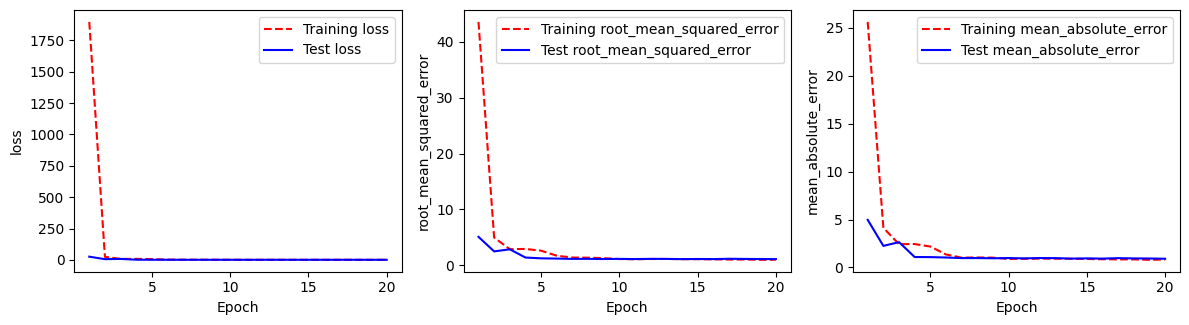

7/7 [==============================] - 1s 141ms/step


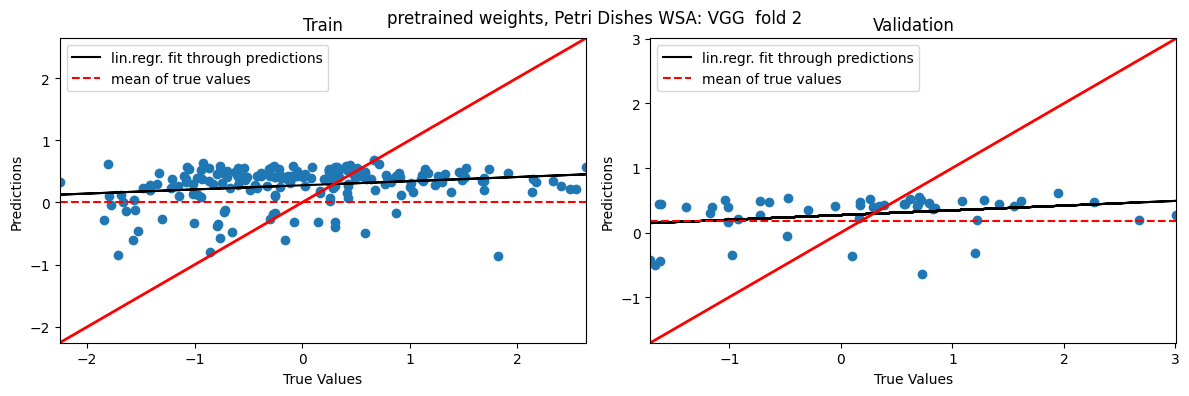

Train RMSE: 1.0165666010236694, MAE: 0.8222704662187788
Validation RMSE: 1.1255730283422352, MAE: 0.9055669637003629
------------------------------------------------------------------
------------------------------Fold 2------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 3s 227ms/step - loss: 2111.6604 - mean_absolute_error: 34.7144 - root_mean_squared_error: 45.9528 - val_loss: 154.4689 - val_mean_absolute_error: 12.3721 - val_root_mean_squared_error: 12.4286
Epoch 2/20
7/7 [==============================] - 1s 196ms/step - loss: 106.9691 - mean_absolute_error: 9.0192 - root_mean_squared_error: 10.3426 - val_loss: 45.9520 - val_mean_absolute_error: 6.5850 - val_root_mean_squared_error: 6.7788
Epoch 3/20
7/7 [==============================] - 1s 195ms/step - loss: 30.3699 - mean_absolute_error: 4.6736 - root_mean_squared_error: 5.5109 - val_loss: 5.1841 - val_mean_absolute_error: 1.9952 - va

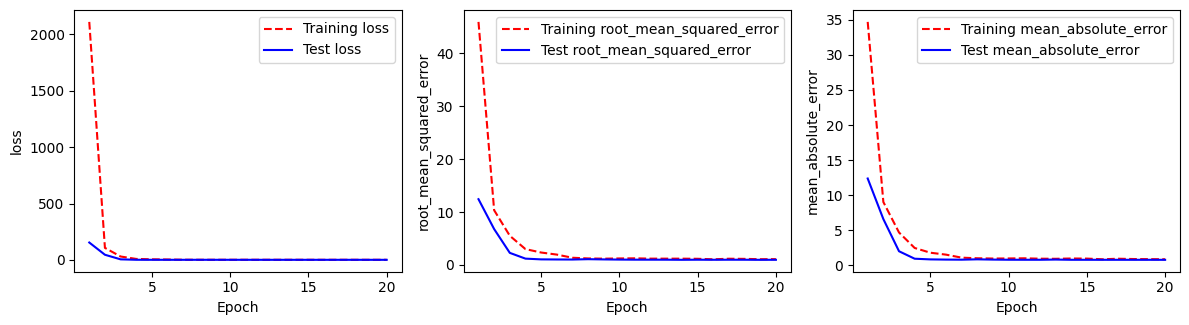

7/7 [==============================] - 1s 146ms/step


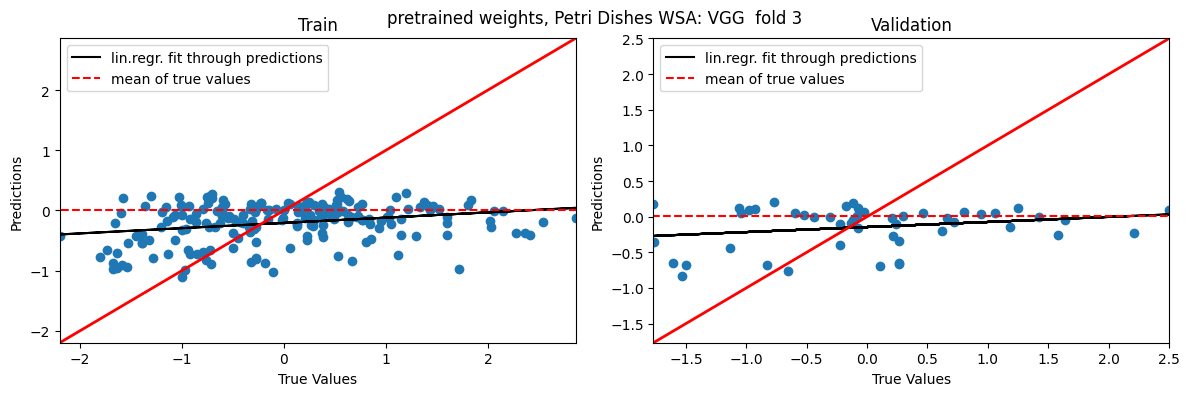

Train RMSE: 0.9864255409348806, MAE: 0.7698777707409242
Validation RMSE: 0.9680775472468236, MAE: 0.7708370423080142
------------------------------------------------------------------
------------------------------Fold 3------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 3s 233ms/step - loss: 2197.8457 - mean_absolute_error: 29.2140 - root_mean_squared_error: 46.8812 - val_loss: 50.8117 - val_mean_absolute_error: 7.0182 - val_root_mean_squared_error: 7.1282
Epoch 2/20
7/7 [==============================] - 1s 187ms/step - loss: 33.2985 - mean_absolute_error: 4.9233 - root_mean_squared_error: 5.7705 - val_loss: 1.3620 - val_mean_absolute_error: 1.0009 - val_root_mean_squared_error: 1.1671
Epoch 3/20
7/7 [==============================] - 1s 193ms/step - loss: 14.5550 - mean_absolute_error: 3.0673 - root_mean_squared_error: 3.8151 - val_loss: 2.3393 - val_mean_absolute_error: 1.1832 - val_root

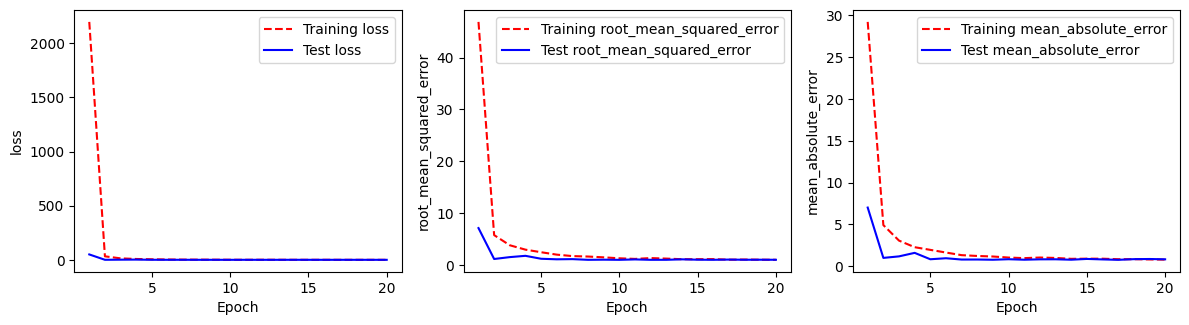

7/7 [==============================] - 1s 142ms/step


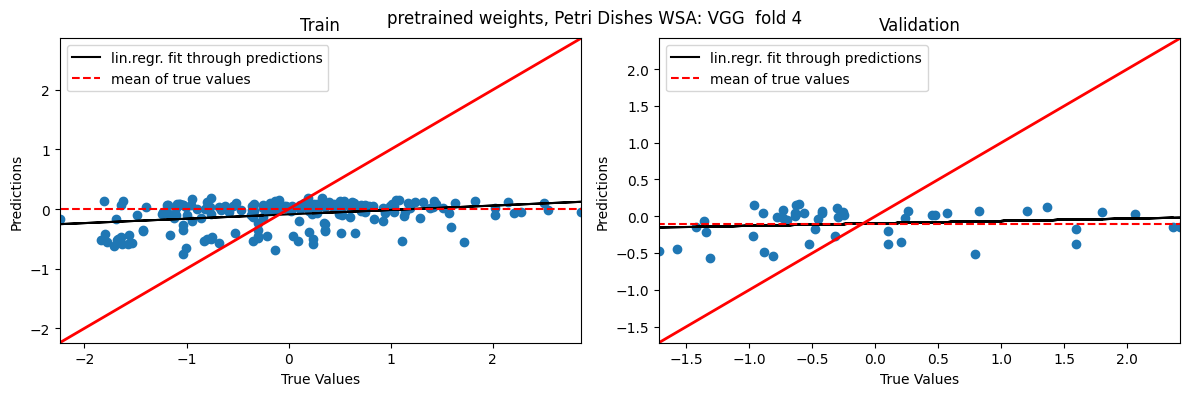

Train RMSE: 0.9547858605704898, MAE: 0.7635639823443291
Validation RMSE: 1.016404345834206, MAE: 0.8318816615504275
------------------------------------------------------------------
------------------------------Fold 4------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 3s 228ms/step - loss: 1927.9177 - mean_absolute_error: 27.4016 - root_mean_squared_error: 43.9081 - val_loss: 29.8177 - val_mean_absolute_error: 5.3621 - val_root_mean_squared_error: 5.4606
Epoch 2/20
7/7 [==============================] - 1s 190ms/step - loss: 24.0190 - mean_absolute_error: 4.2879 - root_mean_squared_error: 4.9009 - val_loss: 1.2231 - val_mean_absolute_error: 0.8972 - val_root_mean_squared_error: 1.1059
Epoch 3/20
7/7 [==============================] - 1s 191ms/step - loss: 10.2825 - mean_absolute_error: 2.7008 - root_mean_squared_error: 3.2066 - val_loss: 1.1257 - val_mean_absolute_error: 0.8537 - val_root_

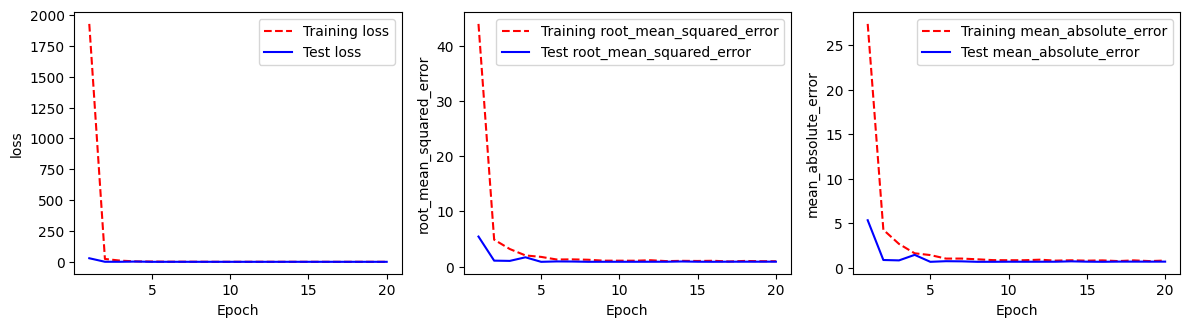

7/7 [==============================] - 1s 149ms/step


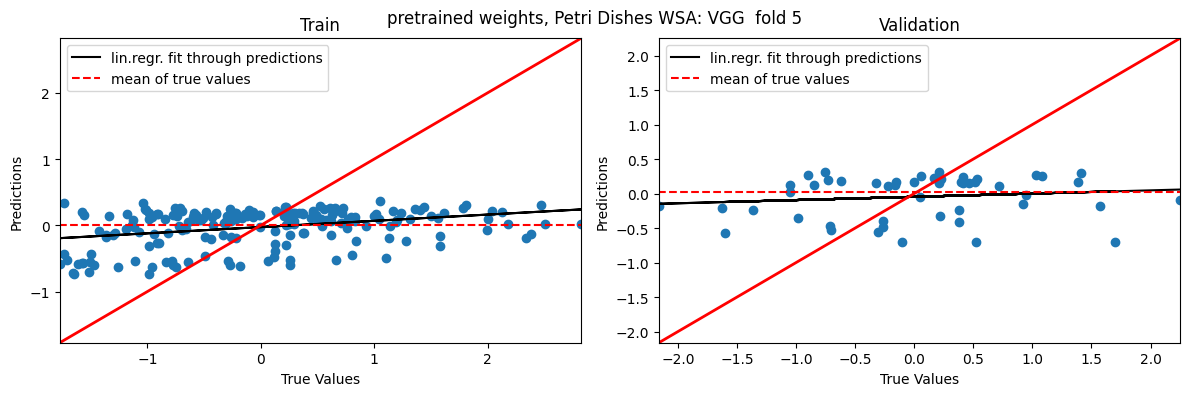

Train RMSE: 0.9433583198800745, MAE: 0.7623165794204512
Validation RMSE: 0.9193126820259714, MAE: 0.7142543134025856


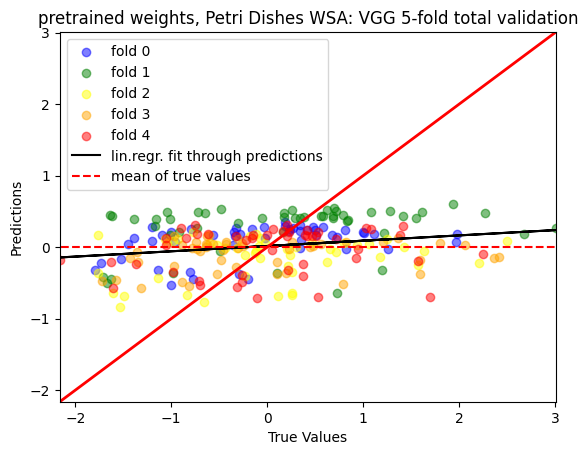

Total validation RMSE: 0.980358270946974
Total validation MAE: 0.7787920421272789


In [27]:
run_5fold('VGG','pretrained weights, Petri Dishes','WSA', model_dict,splits,X_col,y,True,build_vgg,True,True)

#ResNet

## Random weights

------------------------------------------------------------------
------------------------------Fold 0------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 3s 236ms/step - loss: 1.0009 - mean_absolute_error: 0.8077 - root_mean_squared_error: 1.0005 - val_loss: 0.8146 - val_mean_absolute_error: 0.7430 - val_root_mean_squared_error: 0.9026
Epoch 2/20
7/7 [==============================] - 1s 187ms/step - loss: 0.9999 - mean_absolute_error: 0.8073 - root_mean_squared_error: 1.0000 - val_loss: 0.8154 - val_mean_absolute_error: 0.7432 - val_root_mean_squared_error: 0.9030
Epoch 3/20
7/7 [==============================] - 1s 191ms/step - loss: 0.9999 - mean_absolute_error: 0.8074 - root_mean_squared_error: 1.0000 - val_loss: 0.8157 - val_mean_absolute_error: 0.7433 - val_root_mean_squared_error: 0.9032
Epoch 4/20
7/7 [==============================] - 1s 186ms/step - loss: 1.0001 - mean_absolute_er

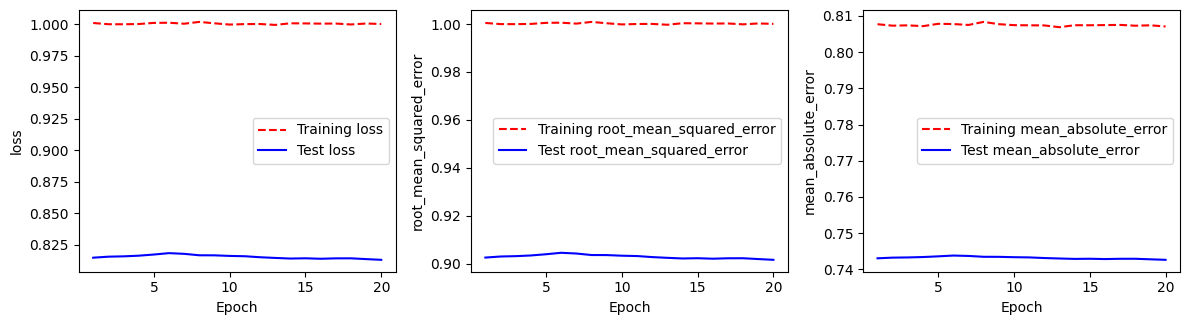

7/7 [==============================] - 1s 144ms/step


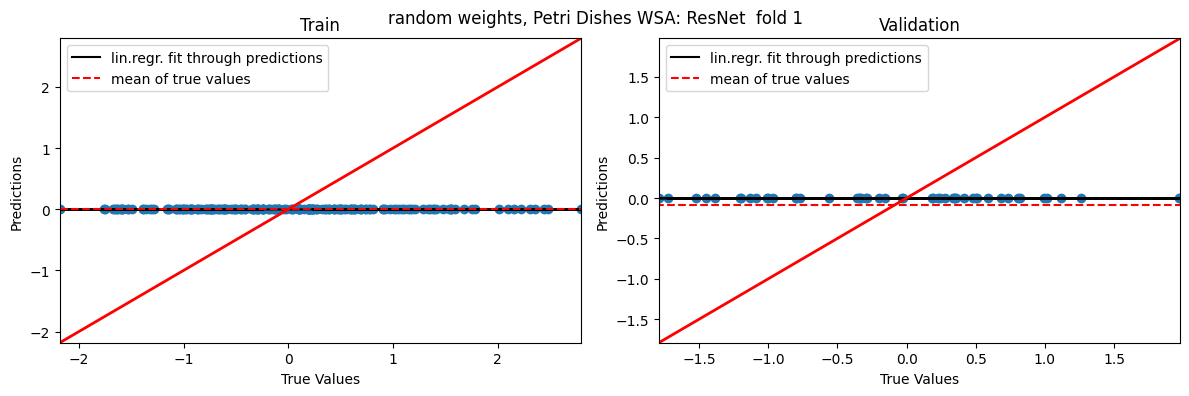

Train RMSE: 1.0000003390067609, MAE: 0.8070890790991414
Validation RMSE: 0.9016291468414276, MAE: 0.742593857181658
------------------------------------------------------------------
------------------------------Fold 1------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 3s 250ms/step - loss: 1.0018 - mean_absolute_error: 0.8030 - root_mean_squared_error: 1.0009 - val_loss: 1.3828 - val_mean_absolute_error: 0.9843 - val_root_mean_squared_error: 1.1759
Epoch 2/20
7/7 [==============================] - 1s 200ms/step - loss: 0.9997 - mean_absolute_error: 0.8023 - root_mean_squared_error: 0.9999 - val_loss: 1.3840 - val_mean_absolute_error: 0.9850 - val_root_mean_squared_error: 1.1764
Epoch 3/20
7/7 [==============================] - 1s 200ms/step - loss: 1.0002 - mean_absolute_error: 0.8019 - root_mean_squared_error: 1.0001 - val_loss: 1.3859 - val_mean_absolute_error: 0.9861 - val_root_mean_squ

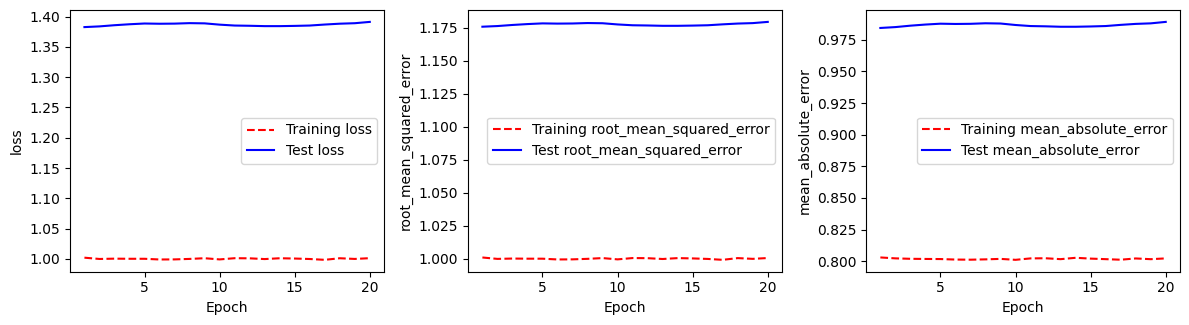

7/7 [==============================] - 1s 141ms/step


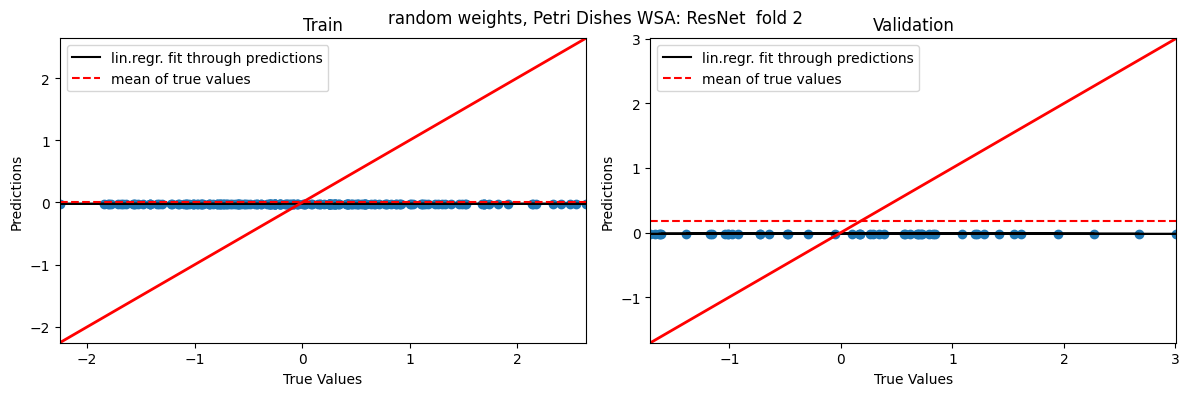

Train RMSE: 1.0001685743784132, MAE: 0.8012315644159153
Validation RMSE: 1.1795863768565134, MAE: 0.9890864425676308
------------------------------------------------------------------
------------------------------Fold 2------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 3s 240ms/step - loss: 1.0026 - mean_absolute_error: 0.8172 - root_mean_squared_error: 1.0013 - val_loss: 0.9693 - val_mean_absolute_error: 0.7678 - val_root_mean_squared_error: 0.9845
Epoch 2/20
7/7 [==============================] - 1s 182ms/step - loss: 1.0002 - mean_absolute_error: 0.8167 - root_mean_squared_error: 1.0001 - val_loss: 0.9692 - val_mean_absolute_error: 0.7672 - val_root_mean_squared_error: 0.9845
Epoch 3/20
7/7 [==============================] - 1s 183ms/step - loss: 0.9990 - mean_absolute_error: 0.8161 - root_mean_squared_error: 0.9995 - val_loss: 0.9693 - val_mean_absolute_error: 0.7666 - val_root_mean_sq

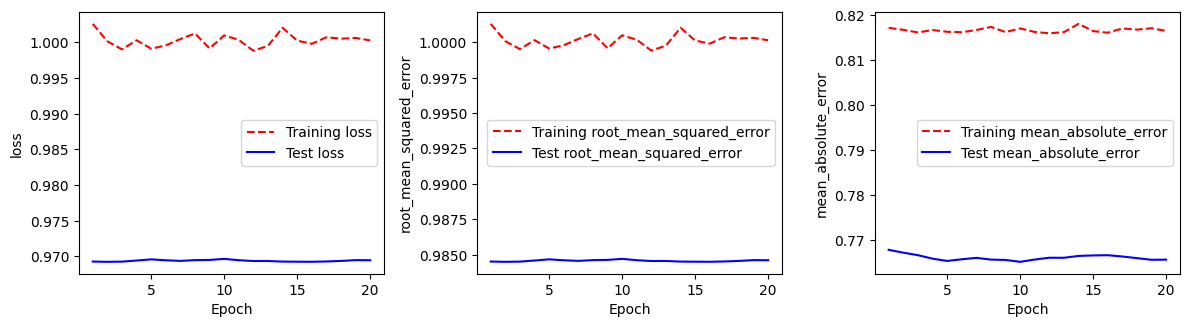

7/7 [==============================] - 1s 139ms/step


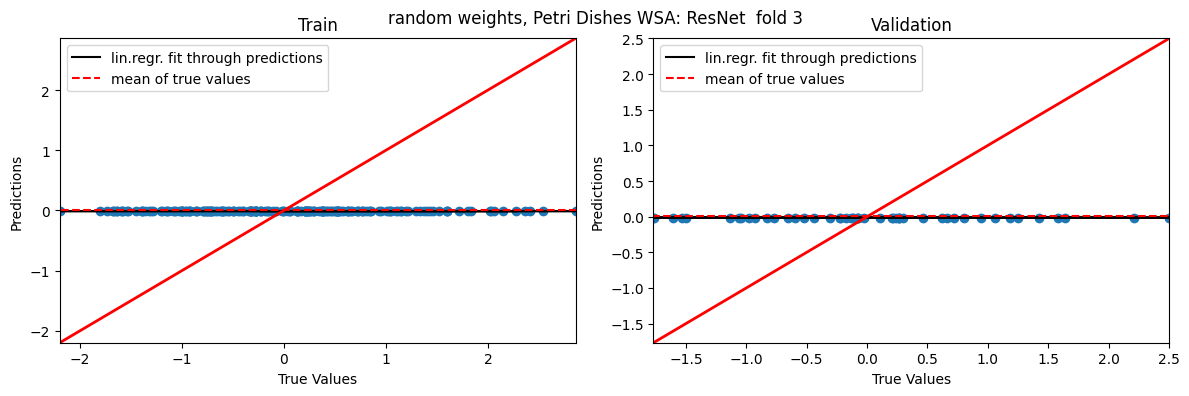

Train RMSE: 1.0000268494260602, MAE: 0.8164870170888232
Validation RMSE: 0.9846077436652187, MAE: 0.7656195043453001
------------------------------------------------------------------
------------------------------Fold 3------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 4s 248ms/step - loss: 1.0009 - mean_absolute_error: 0.8045 - root_mean_squared_error: 1.0005 - val_loss: 1.0727 - val_mean_absolute_error: 0.8609 - val_root_mean_squared_error: 1.0357
Epoch 2/20
7/7 [==============================] - 1s 192ms/step - loss: 1.0003 - mean_absolute_error: 0.8043 - root_mean_squared_error: 1.0001 - val_loss: 1.0738 - val_mean_absolute_error: 0.8621 - val_root_mean_squared_error: 1.0363
Epoch 3/20
7/7 [==============================] - 1s 190ms/step - loss: 1.0007 - mean_absolute_error: 0.8044 - root_mean_squared_error: 1.0003 - val_loss: 1.0739 - val_mean_absolute_error: 0.8622 - val_root_mean_sq

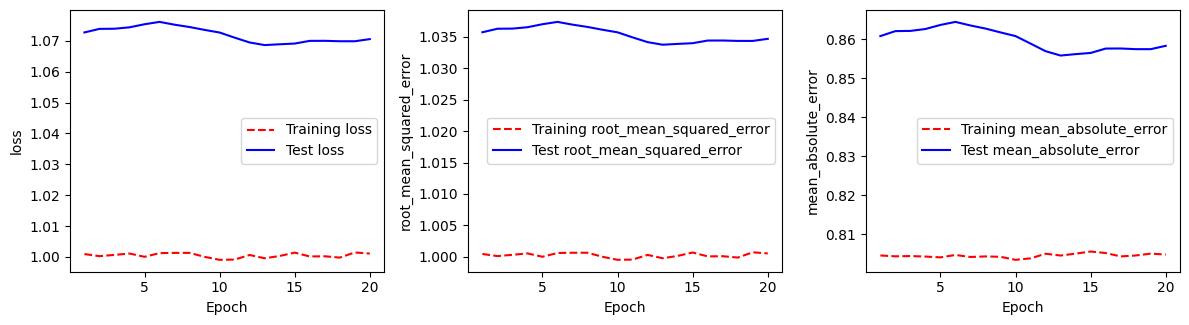

7/7 [==============================] - 1s 140ms/step


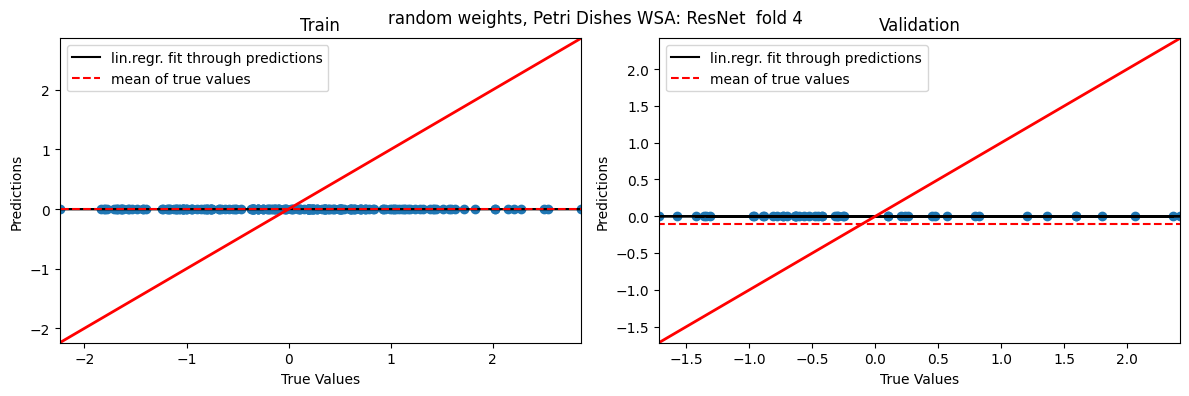

Train RMSE: 0.9999652017576949, MAE: 0.8045287348454578
Validation RMSE: 1.0346592627022086, MAE: 0.8583718562187936
------------------------------------------------------------------
------------------------------Fold 4------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 3s 238ms/step - loss: 1.0020 - mean_absolute_error: 0.8141 - root_mean_squared_error: 1.0010 - val_loss: 0.8227 - val_mean_absolute_error: 0.7173 - val_root_mean_squared_error: 0.9071
Epoch 2/20
7/7 [==============================] - 1s 196ms/step - loss: 0.9997 - mean_absolute_error: 0.8133 - root_mean_squared_error: 0.9999 - val_loss: 0.8226 - val_mean_absolute_error: 0.7171 - val_root_mean_squared_error: 0.9070
Epoch 3/20
7/7 [==============================] - 1s 199ms/step - loss: 1.0000 - mean_absolute_error: 0.8135 - root_mean_squared_error: 1.0000 - val_loss: 0.8229 - val_mean_absolute_error: 0.7175 - val_root_mean_sq

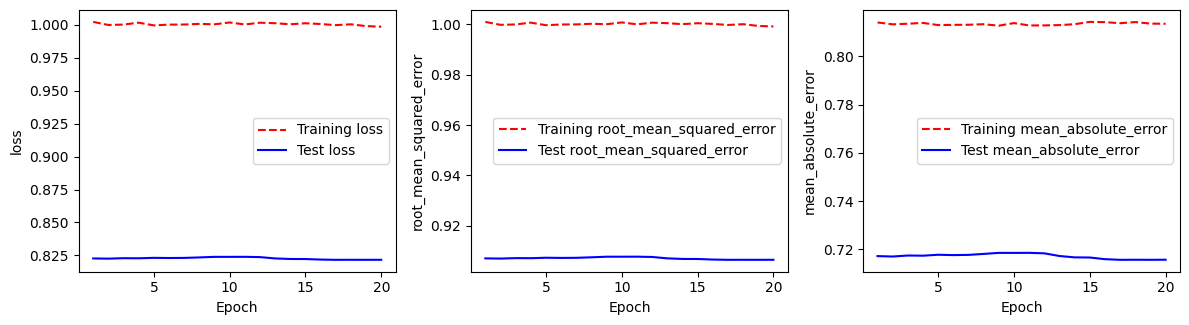

7/7 [==============================] - 1s 139ms/step


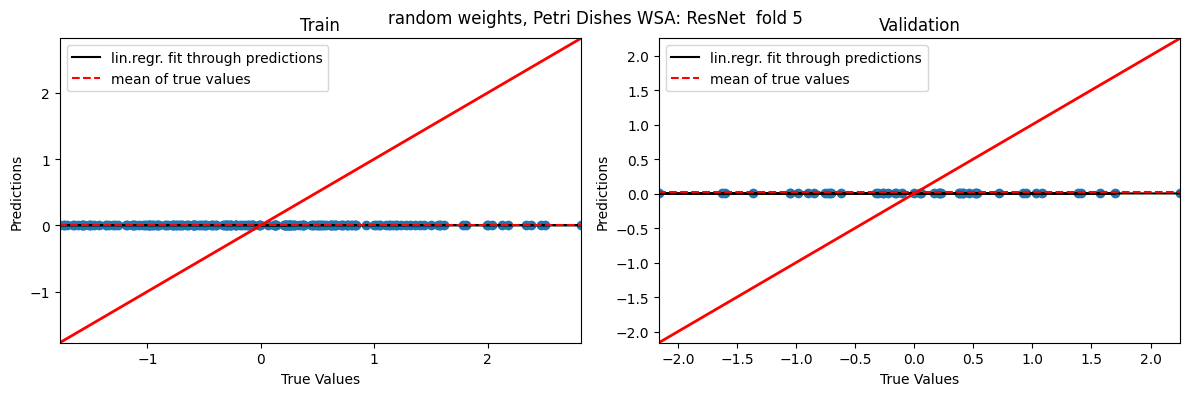

Train RMSE: 0.9999565255067793, MAE: 0.8141389357836633
Validation RMSE: 0.9064933740771293, MAE: 0.7157602214194436


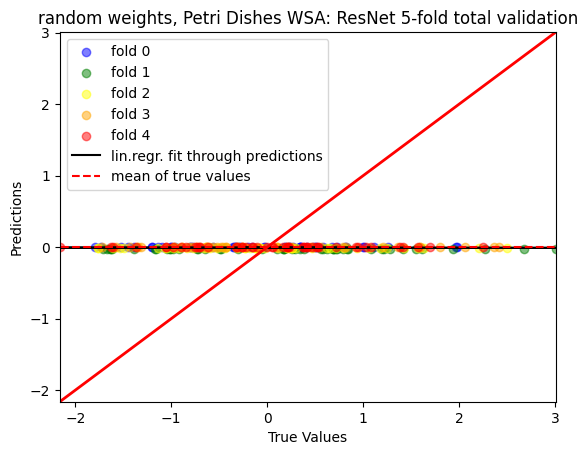

Total validation RMSE: 1.0069422513791364
Total validation MAE: 0.8147038158083308


In [28]:
run_5fold('ResNet','random weights, Petri Dishes','WSA', model_dict,splits,X_col_norm,y,True,build_vgg,True,False)

## Pretrained weights

------------------------------------------------------------------
------------------------------Fold 0------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 3s 225ms/step - loss: 11.1364 - mean_absolute_error: 2.7151 - root_mean_squared_error: 3.3371 - val_loss: 1.1602 - val_mean_absolute_error: 0.9034 - val_root_mean_squared_error: 1.0771
Epoch 2/20
7/7 [==============================] - 1s 190ms/step - loss: 6.4113 - mean_absolute_error: 1.9404 - root_mean_squared_error: 2.5320 - val_loss: 1.0127 - val_mean_absolute_error: 0.7913 - val_root_mean_squared_error: 1.0063
Epoch 3/20
7/7 [==============================] - 1s 190ms/step - loss: 3.3769 - mean_absolute_error: 1.5021 - root_mean_squared_error: 1.8376 - val_loss: 0.8025 - val_mean_absolute_error: 0.7256 - val_root_mean_squared_error: 0.8958
Epoch 4/20
7/7 [==============================] - 1s 193ms/step - loss: 2.0985 - mean_absolute_e

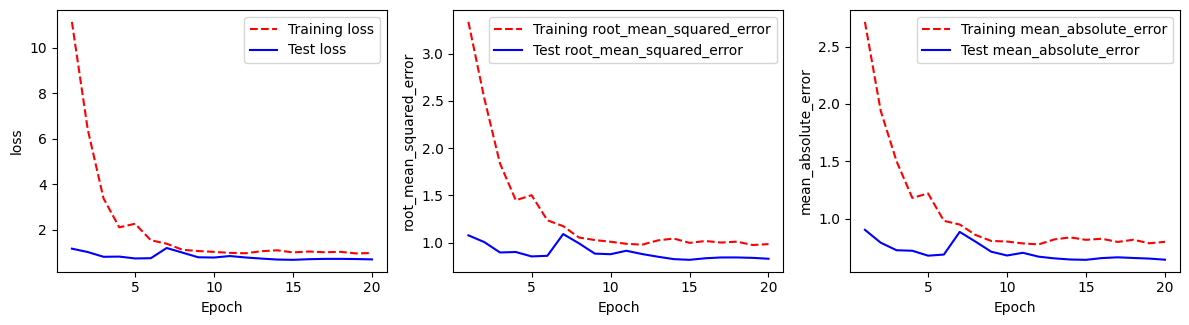

7/7 [==============================] - 1s 146ms/step


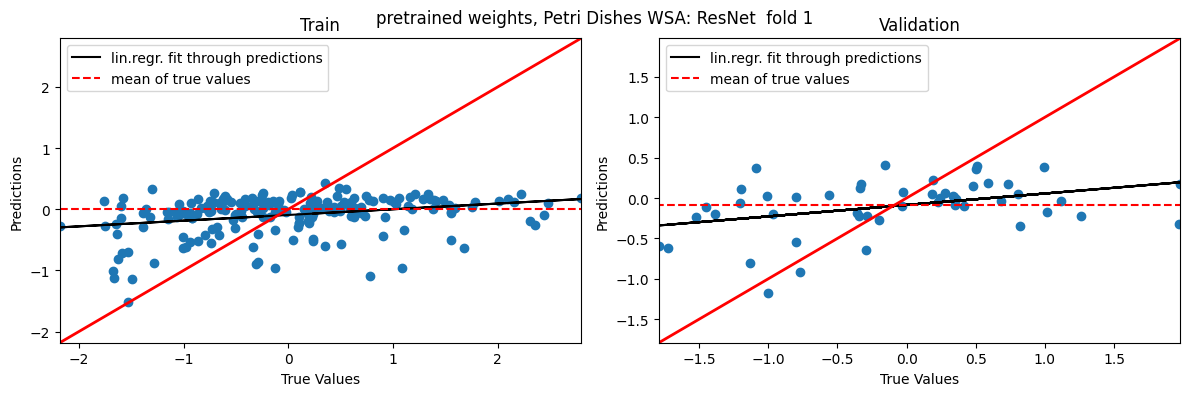

Train RMSE: 0.9618234577317518, MAE: 0.7716116242949183
Validation RMSE: 0.8293693547276533, MAE: 0.6432042900030698
------------------------------------------------------------------
------------------------------Fold 1------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 3s 247ms/step - loss: 16.1761 - mean_absolute_error: 3.2442 - root_mean_squared_error: 4.0220 - val_loss: 2.7728 - val_mean_absolute_error: 1.2702 - val_root_mean_squared_error: 1.6652
Epoch 2/20
7/7 [==============================] - 1s 186ms/step - loss: 13.1994 - mean_absolute_error: 2.9232 - root_mean_squared_error: 3.6331 - val_loss: 5.0479 - val_mean_absolute_error: 1.9000 - val_root_mean_squared_error: 2.2467
Epoch 3/20
7/7 [==============================] - 1s 192ms/step - loss: 6.7688 - mean_absolute_error: 2.0672 - root_mean_squared_error: 2.6017 - val_loss: 1.9134 - val_mean_absolute_error: 1.1564 - val_root_mean_

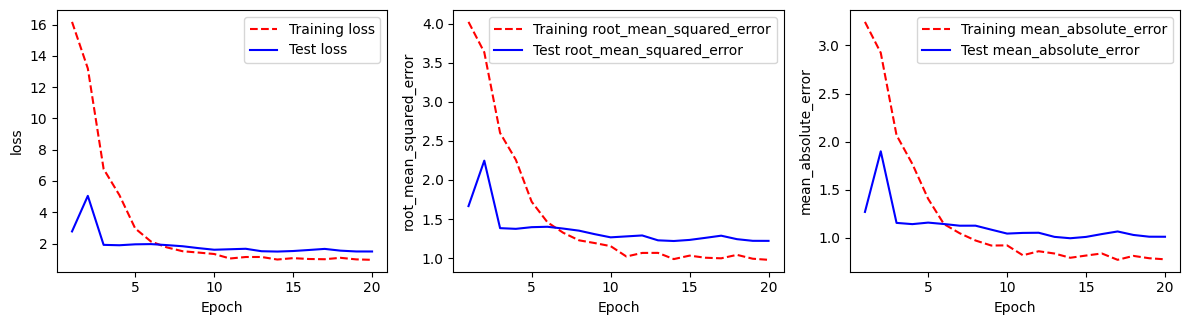

7/7 [==============================] - 1s 142ms/step


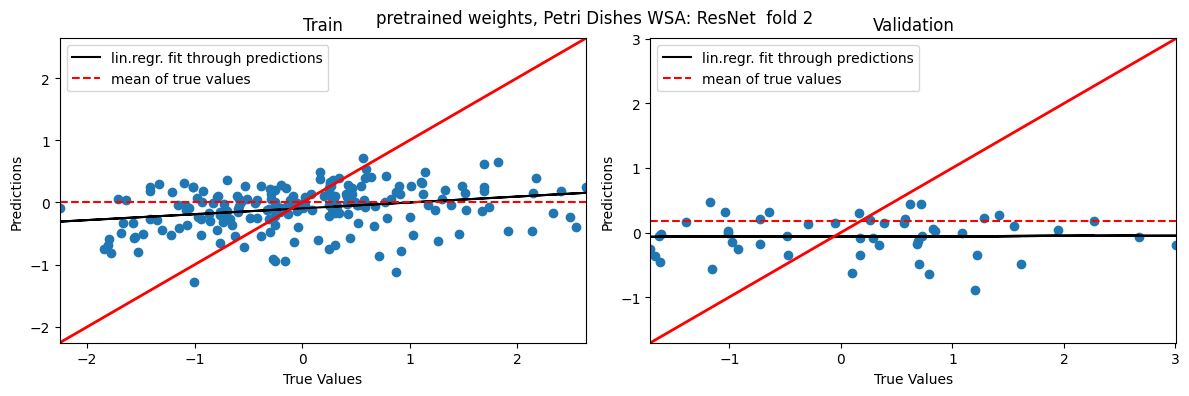

Train RMSE: 0.9694510285749458, MAE: 0.7523499759664448
Validation RMSE: 1.2204892948570234, MAE: 1.0124079217300537
------------------------------------------------------------------
------------------------------Fold 2------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 3s 234ms/step - loss: 11.0658 - mean_absolute_error: 2.6304 - root_mean_squared_error: 3.3265 - val_loss: 3.5261 - val_mean_absolute_error: 1.5472 - val_root_mean_squared_error: 1.8778
Epoch 2/20
7/7 [==============================] - 1s 184ms/step - loss: 6.4769 - mean_absolute_error: 1.9871 - root_mean_squared_error: 2.5450 - val_loss: 1.6502 - val_mean_absolute_error: 0.9793 - val_root_mean_squared_error: 1.2846
Epoch 3/20
7/7 [==============================] - 1s 182ms/step - loss: 3.5876 - mean_absolute_error: 1.5172 - root_mean_squared_error: 1.8941 - val_loss: 1.0972 - val_mean_absolute_error: 0.8732 - val_root_mean_s

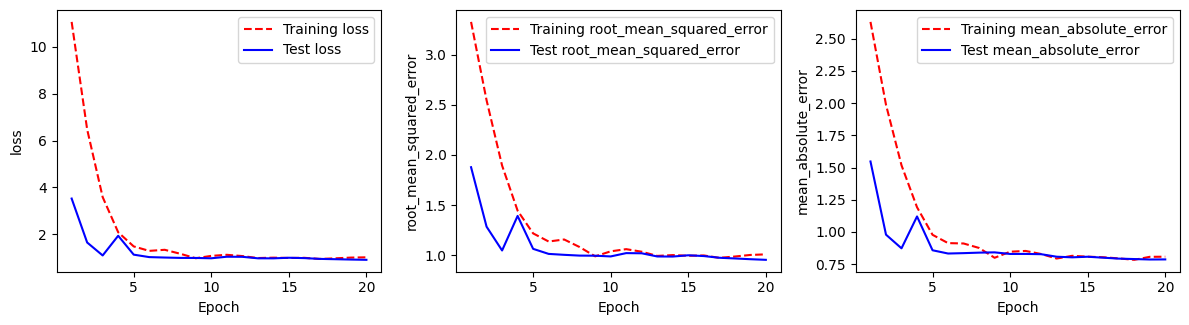

7/7 [==============================] - 1s 142ms/step


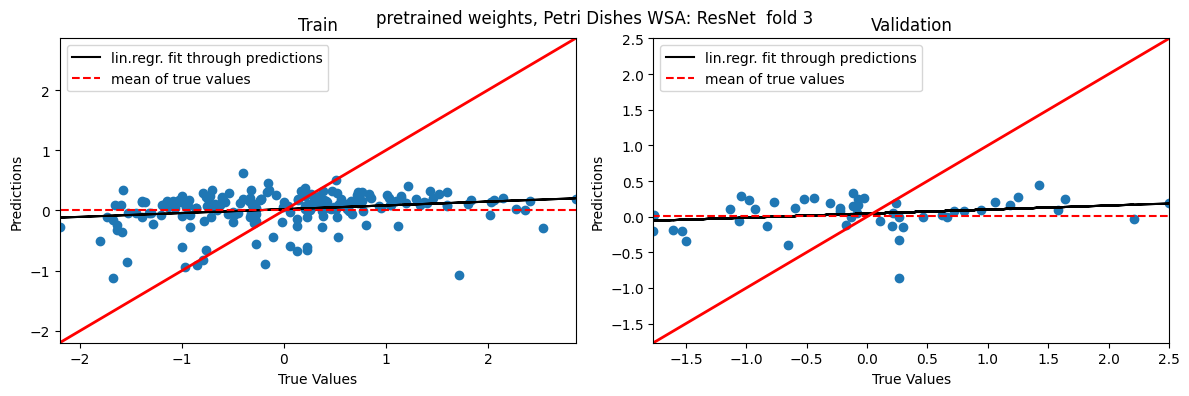

Train RMSE: 0.9768929765019881, MAE: 0.7922162315542907
Validation RMSE: 0.9543294885316866, MAE: 0.7871566313755912
------------------------------------------------------------------
------------------------------Fold 3------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 3s 218ms/step - loss: 17.2111 - mean_absolute_error: 3.3311 - root_mean_squared_error: 4.1486 - val_loss: 2.1990 - val_mean_absolute_error: 1.3042 - val_root_mean_squared_error: 1.4829
Epoch 2/20
7/7 [==============================] - 1s 192ms/step - loss: 7.0662 - mean_absolute_error: 2.1365 - root_mean_squared_error: 2.6582 - val_loss: 1.5974 - val_mean_absolute_error: 0.9869 - val_root_mean_squared_error: 1.2639
Epoch 3/20
7/7 [==============================] - 1s 193ms/step - loss: 4.5559 - mean_absolute_error: 1.6993 - root_mean_squared_error: 2.1345 - val_loss: 1.3780 - val_mean_absolute_error: 0.9214 - val_root_mean_s

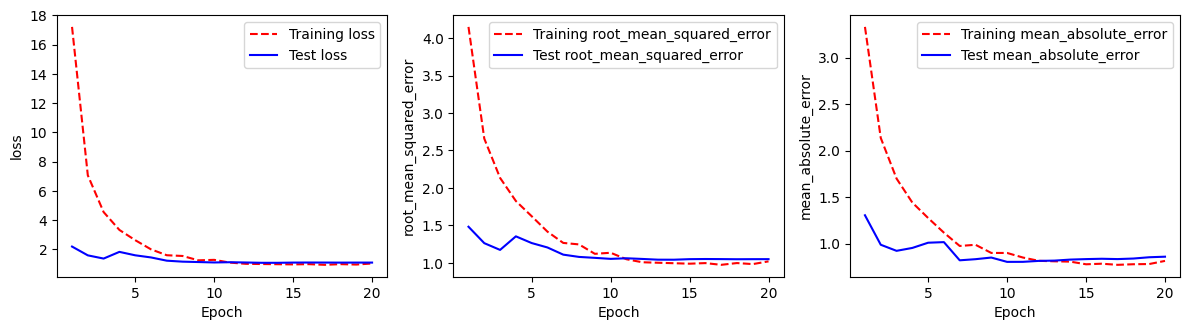

7/7 [==============================] - 1s 148ms/step


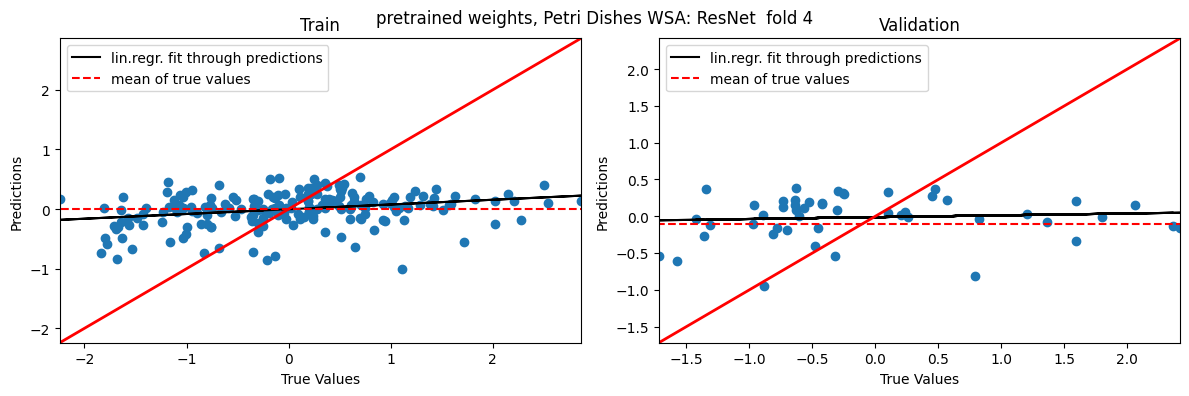

Train RMSE: 0.9596482006027266, MAE: 0.7570265411018348
Validation RMSE: 1.0505780424917637, MAE: 0.8583501930889731
------------------------------------------------------------------
------------------------------Fold 4------------------------------
------------------------------------------------------------------
Epoch 1/20
7/7 [==============================] - 3s 231ms/step - loss: 16.0720 - mean_absolute_error: 3.0793 - root_mean_squared_error: 4.0090 - val_loss: 9.4409 - val_mean_absolute_error: 2.7759 - val_root_mean_squared_error: 3.0726
Epoch 2/20
7/7 [==============================] - 1s 197ms/step - loss: 9.6238 - mean_absolute_error: 2.5219 - root_mean_squared_error: 3.1022 - val_loss: 1.3740 - val_mean_absolute_error: 0.9564 - val_root_mean_squared_error: 1.1722
Epoch 3/20
7/7 [==============================] - 1s 200ms/step - loss: 5.5319 - mean_absolute_error: 1.9371 - root_mean_squared_error: 2.3520 - val_loss: 4.4386 - val_mean_absolute_error: 1.8392 - val_root_mean_s

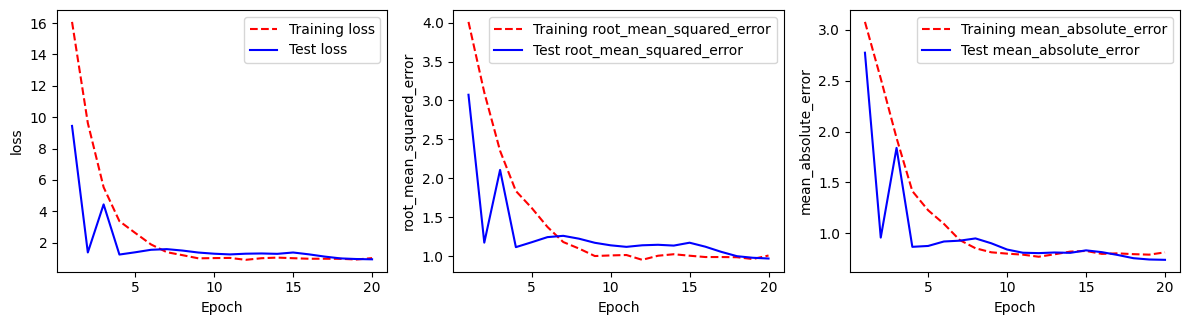

7/7 [==============================] - 1s 151ms/step


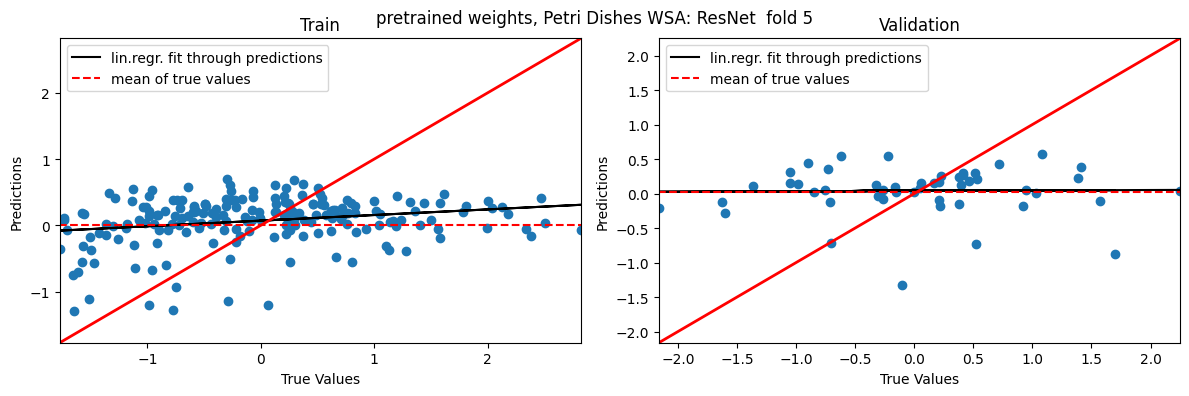

Train RMSE: 0.9841853785873805, MAE: 0.8021433476883456
Validation RMSE: 0.9679179335920777, MAE: 0.7375632913916718


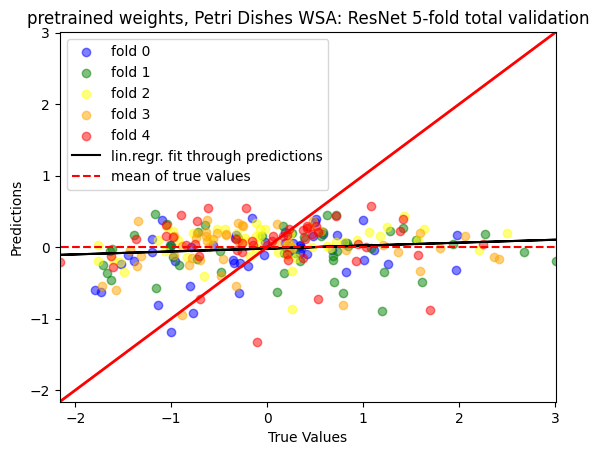

Total validation RMSE: 1.013047001758565
Total validation MAE: 0.8078989727271729


In [29]:
run_5fold('ResNet','pretrained weights, Petri Dishes','WSA', model_dict,splits,X_col,y,True,build_vgg,True,True)